In [3]:
import pandas as pd 
import numpy as np
from forex_python.converter import CurrencyRates
import re
import matplotlib.pyplot as plt
import random
import seaborn as sns
from datetime import datetime, timedelta
import time
import os


import warnings
warnings.filterwarnings('ignore')



# Expedia cleaning


In [4]:
Expedia_hotels = pd.read_csv(r"C:\Users\yarin\Data Science - College Of Management\Year 2\Semester 2\Data Science Fundementals\Final Project\DSF-final project\Notebooks\expedia\Expedia_hotels.csv")

In [5]:
expedia_df = Expedia_hotels.copy()

In [6]:
expedia_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Snapshot                45000 non-null  object 
 1   Index                   45000 non-null  int64  
 2   Hotel Name              45000 non-null  object 
 3   TTT                     45000 non-null  float64
 4   LOS                     45000 non-null  float64
 5   Grade                   44217 non-null  float64
 6   Num of Reviews          44217 non-null  object 
 7   Curr Price              45000 non-null  object 
 8   Original Price          20597 non-null  object 
 9   Percentage of discount  45000 non-null  float64
 10  Distance from center    45000 non-null  float64
 11  Type of room            45000 non-null  float64
 12  Location grade          45000 non-null  float64
 13  Is refundable           45000 non-null  bool   
 14  Late payment            45000 non-null

In [7]:
#taking only the date form the timestamp
expedia_df['Snapshot'] = expedia_df['Snapshot'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
#keep the firt 100 hotels in each search
expedia_df = expedia_df.loc[expedia_df['Index'] < 100].reset_index(drop=True)

#increase the index in one to avoid the 0 index
expedia_df['Index'] = expedia_df['Index'] + 1

#convert from float to int
expedia_df['TTT'] = expedia_df['TTT'].astype('int64')
expedia_df['LOS'] = expedia_df['LOS'].astype('int64')

In [8]:
#we can see that we have 6 hotels with no grade, we can check if they have reviews
expedia_df.loc[pd.isnull(expedia_df['Grade'])]['Hotel Name'].value_counts()

The FIDI Hotel                           222
Latisha luxury place                     173
The Flat NYC                             120
Moxy Brooklyn Willamsburg                115
The Ritz-Carlton New York, NoMad         108
Latisha house                             28
Lovely 2 Bedroom In Brooklyn Sleeps 5     16
Untitled at 3 Freeman Alley                1
Name: Hotel Name, dtype: int64

In [9]:
#we see that the hotels without grade have no reviews
expedia_df.loc[pd.isnull(expedia_df['Num of Reviews'])]['Hotel Name'].value_counts()

The FIDI Hotel                           222
Latisha luxury place                     173
The Flat NYC                             120
Moxy Brooklyn Willamsburg                115
The Ritz-Carlton New York, NoMad         108
Latisha house                             28
Lovely 2 Bedroom In Brooklyn Sleeps 5     16
Untitled at 3 Freeman Alley                1
Name: Hotel Name, dtype: int64

In [10]:
#keep only the digits
expedia_df['Num of Reviews'] = expedia_df['Num of Reviews'].apply(lambda x: int(re.sub("[^0-9]", "", x)) if not pd.isnull(x) else x)


In [11]:
#check how much hotels have only one review, that can tell us if the hotels without reviews are likely to have zero reviews
expedia_df.loc[expedia_df['Num of Reviews'] == 1].shape

(38, 17)

In [12]:
expedia_df['Num of Reviews'] = expedia_df['Num of Reviews'].fillna(0)

In [13]:
expedia_df['Grade'].describe()

count    44217.000000
mean         8.410114
std          0.644215
min          5.600000
25%          8.000000
50%          8.600000
75%          8.800000
max         10.000000
Name: Grade, dtype: float64

(array([  170.,   127.,   735.,  1732.,  2791., 10976., 11705., 11122.,
         4204.,   655.]),
 array([ 5.6 ,  6.04,  6.48,  6.92,  7.36,  7.8 ,  8.24,  8.68,  9.12,
         9.56, 10.  ]),
 <BarContainer object of 10 artists>)

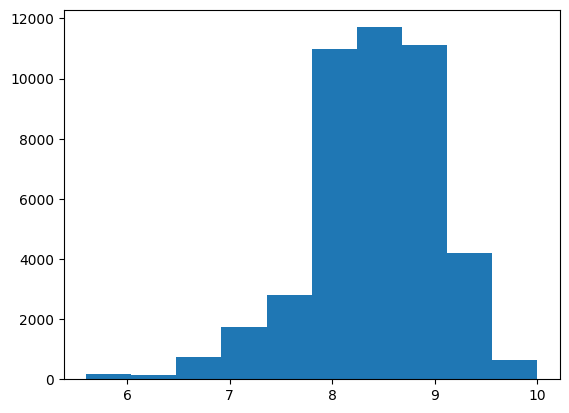

In [14]:
#lets see the histogram of the grades
plt.hist(expedia_df['Grade'])


In [15]:
#we choose to fill the missing values with a random number between 5 and 6 - whiche means that the hotel has a low grade
expedia_df['Grade'] = expedia_df['Grade'].fillna(round(random.uniform(5, 6),1))


In [16]:
expedia_df['Curr Price'] = expedia_df['Curr Price'].apply(lambda x: x.split('€')[1])

In [17]:
expedia_df['Original Price'] = expedia_df['Original Price'].apply(lambda x: x.split('€')[1] if not pd.isnull(x) else x)



In [18]:
expedia_df['Original Price']

0          360
1          NaN
2          493
3          NaN
4          NaN
         ...  
44995    2,352
44996    1,789
44997      NaN
44998      NaN
44999    1,583
Name: Original Price, Length: 45000, dtype: object

In [19]:
#fill the original price with the current price if it is missing
expedia_df['Original Price'] = expedia_df.apply(lambda x: x['Curr Price']  if pd.isnull(x['Original Price']) else x['Original Price'], axis = 1)
expedia_df['Original Price']

0          360
1          217
2          493
3          328
4          428
         ...  
44995    2,352
44996    1,789
44997    2,091
44998    1,816
44999    1,583
Name: Original Price, Length: 45000, dtype: object

In [20]:
#convert the prices to int
expedia_df['Original Price'] = expedia_df['Original Price'].apply(lambda x: int(x.replace(',','')))
expedia_df['Curr Price'] = expedia_df['Curr Price'].apply(lambda x: int(x.replace(',','')))

In [21]:
expedia_df['Original Price']  


0         360
1         217
2         493
3         328
4         428
         ... 
44995    2352
44996    1789
44997    2091
44998    1816
44999    1583
Name: Original Price, Length: 45000, dtype: int64

In [22]:
#create dictionary with the exchange rate for each date
c = CurrencyRates()
x = expedia_df['Snapshot'].unique()
curr_dict = {}
for date in x:
    curr_dict[date] = c.get_rate('EUR','USD', date) 

In [23]:
curr_dict[expedia_df['Snapshot'].loc[0]]

1.0929

In [24]:
expedia_df[['Original Price','Curr Price']]

Original Price  Curr Price
0                 360         278
1                 217         217
2                 493         449
3                 328         328
4                 428         428
...               ...         ...
44995            2352        1908
44996            1789        1373
44997            2091        2091
44998            1816        1816
44999            1583        1426

[45000 rows x 2 columns]

In [25]:
#multiply the prices by the exchange rate and divide by the LOS to get price per night
expedia_df['Original Price'] = expedia_df.apply(lambda x: (x['Original Price']*curr_dict[x['Snapshot']])/x['LOS']  , axis = 1)
expedia_df['Curr Price'] = expedia_df.apply(lambda x: (x['Curr Price']*curr_dict[x['Snapshot']])/x['LOS']  , axis = 1)


In [26]:
expedia_df['Original Price'] = expedia_df['Original Price'].apply(lambda x: round(x,1))
expedia_df['Curr Price'] = expedia_df['Curr Price'].apply(lambda x: round(x,1))

In [27]:
expedia_df[['Original Price','Curr Price']]

Original Price  Curr Price
0               393.4       303.8
1               237.2       237.2
2               538.8       490.7
3               358.5       358.5
4               467.8       467.8
...               ...         ...
44995           521.4       423.0
44996           396.6       304.4
44997           463.5       463.5
44998           402.6       402.6
44999           350.9       316.1

[45000 rows x 2 columns]

In [28]:
#drop unrelevant columns
expedia_df.drop(['Percentage of discount', 'Distance from center', 'Type of room',
       'Location grade'], axis = 1, inplace=True)

In [29]:
#convert the columns to int

expedia_df[['Is refundable','Late payment', 'Option Member']] = expedia_df[['Is refundable','Late payment', 'Option Member']].astype('int64')


In [30]:
expedia_df['Extras included'] = expedia_df['Extras included'].apply(lambda x: 1 if not pd.isnull(x) else 0)


In [31]:
expedia_df['Percent of discount'] = expedia_df.apply(lambda x: 1 - (x['Curr Price']/x['Original Price'])  , axis = 1)
expedia_df['Percent of discount'] = expedia_df['Percent of discount'].apply(lambda x: round(x,2))

In [32]:
expedia_df =expedia_df[['Snapshot', 'Index', 'Hotel Name', 'TTT', 'LOS', 'Grade',
       'Num of Reviews', 'Curr Price', 'Original Price','Percent of discount', 'Is refundable',
       'Late payment', 'Extras included', 'Option Member']]

In [33]:
expedia_df.head(10)


Snapshot  Index                         Hotel Name  TTT  LOS  Grade  \
0  2022-03-06      1                        Hotel 32 32    1    1    8.0   
1  2022-03-06      2  Sonesta Simply Suites Jersey City    1    1    8.4   
2  2022-03-06      3                 Park Lane New York    1    1    8.8   
3  2022-03-06      4                       Arlo Midtown    1    1    9.2   
4  2022-03-06      5      PUBLIC, an Ian Schrager hotel    1    1    8.0   
5  2022-03-06      6           Hard Rock Hotel New York    1    1    9.2   
6  2022-03-06      7          Hotel Edison Times Square    1    1    7.8   
7  2022-03-06      8        YOTEL New York Times Square    1    1    7.0   
8  2022-03-06      9          Moxy Brooklyn Willamsburg    1    1    5.5   
9  2022-03-06     10          New York Marriott Marquis    1    1    9.0   

   Num of Reviews  Curr Price  Original Price  Percent of discount  \
0          1296.0       303.8           393.4                 0.23   
1          1002.0       237.2           237.2                 0.00   
2           305.0       490.7           538.8                 0.09   
3          3123.0       358.5           358.5                 0.00   
4          1465.0       467.8           467.8                 0.00   
5           716.0       592.4           592.4                 0.00   
6          2758.0       279.8           279.8                 0.00   
7          1889.0       240.4           262.3                 0.08   
8             0.0       264.5           264.5                 0.00   
9          1543.0       588.0           588.0                 0.00   

   Is refundable  Late payment  Extras included  Option Member  
0              0             0                0              0  
1              1             0                0              0  
2              0             0                0              0  
3              1             0                0              1  
4              0             0                0              1  
5              1             0                0              1  
6              1             0                1              1  
7              0             0                0              1  
8              0             0                0              0  
9              0             0                0              0

In [34]:
expedia_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Snapshot             45000 non-null  object 
 1   Index                45000 non-null  int64  
 2   Hotel Name           45000 non-null  object 
 3   TTT                  45000 non-null  int64  
 4   LOS                  45000 non-null  int64  
 5   Grade                45000 non-null  float64
 6   Num of Reviews       45000 non-null  float64
 7   Curr Price           45000 non-null  float64
 8   Original Price       45000 non-null  float64
 9   Percent of discount  45000 non-null  float64
 10  Is refundable        45000 non-null  int64  
 11  Late payment         45000 non-null  int64  
 12  Extras included      45000 non-null  int64  
 13  Option Member        45000 non-null  int64  
dtypes: float64(5), int64(7), object(2)
memory usage: 4.8+ MB


# Expedia EDA

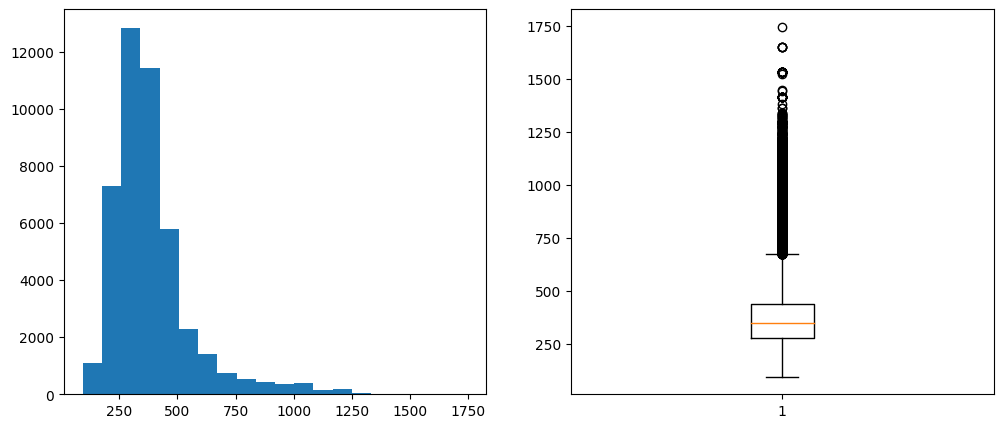

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.hist(expedia_df['Curr Price'], bins=20)
ax2.boxplot(expedia_df['Curr Price'])
plt.show()

In [36]:
expedia_q1=expedia_df['Curr Price'].quantile(0.25)
expedia_q3=expedia_df['Curr Price'].quantile(0.75)

price_IQR = expedia_q3-expedia_q1

prices_lower_limit = expedia_q1 - (1.5 * price_IQR)
prices_upper_limit = expedia_q3 + (1.5 * price_IQR)

price_filter = expedia_df['Curr Price'].apply(lambda x: x > prices_lower_limit and x < prices_upper_limit)

expedia_df = expedia_df.loc[price_filter].reset_index(drop=True)


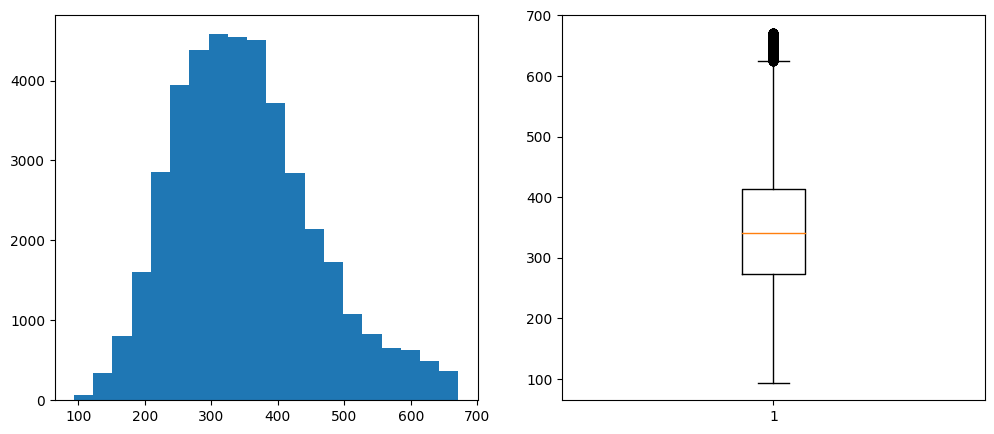

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.hist(expedia_df['Curr Price'], bins=20)
ax2.boxplot(expedia_df['Curr Price'])
plt.show()

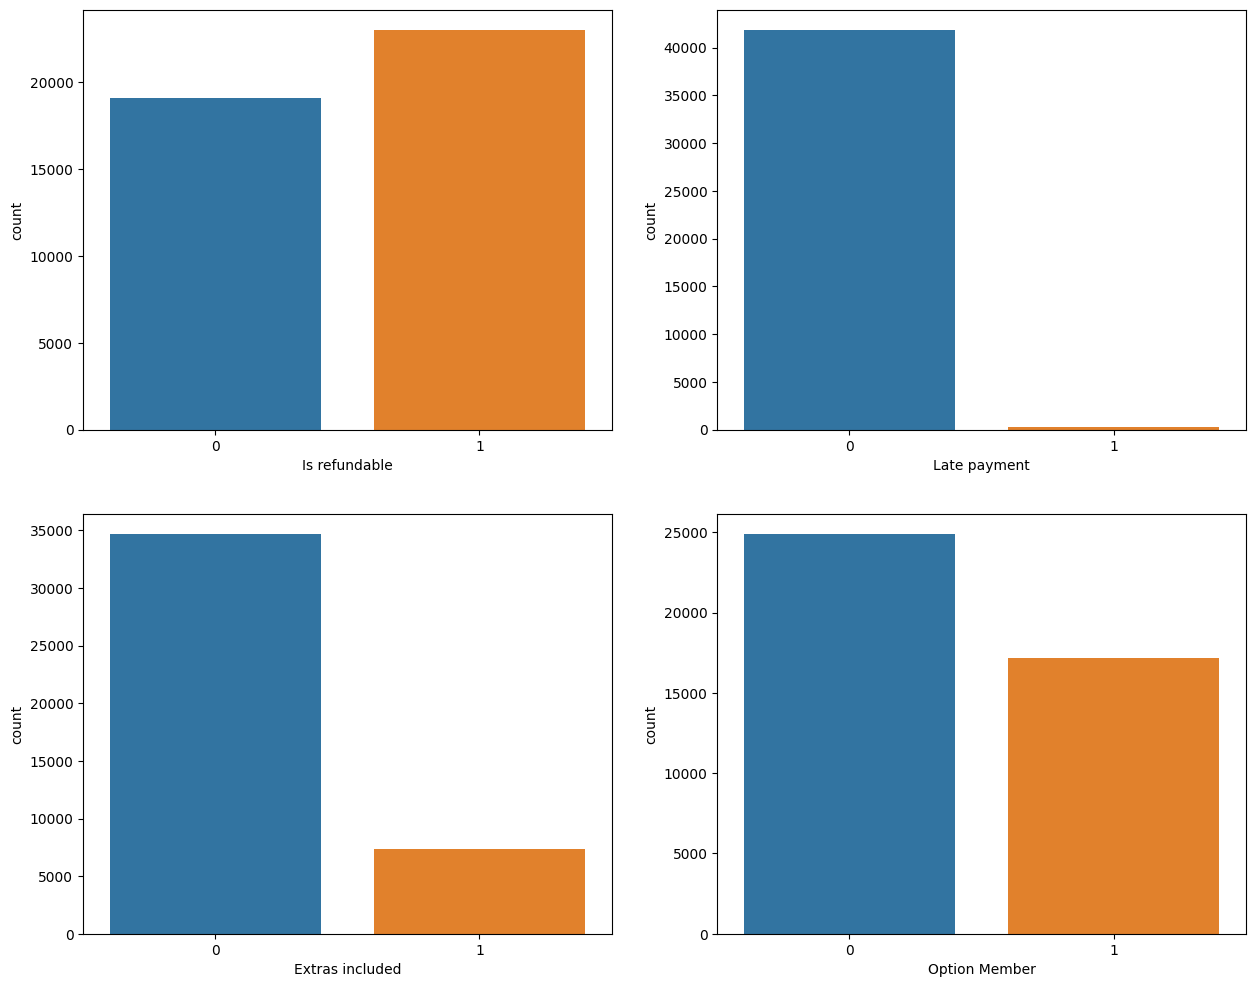

In [38]:
fig,axes = plt.subplots(2,2,figsize=(15,12))
for col,ax in zip(expedia_df.columns[10:],axes.flatten()):
    sns.countplot(data=expedia_df,x=col,ax=ax)

ניתן לראות שכמות המלונות שמאפשרים תשלום מאוחר וכמות המלונות שיש להם אקסטרות היא קטנה ביחס לכמות המלונות ללא תשלום מאוחר וללא אקסטרות 

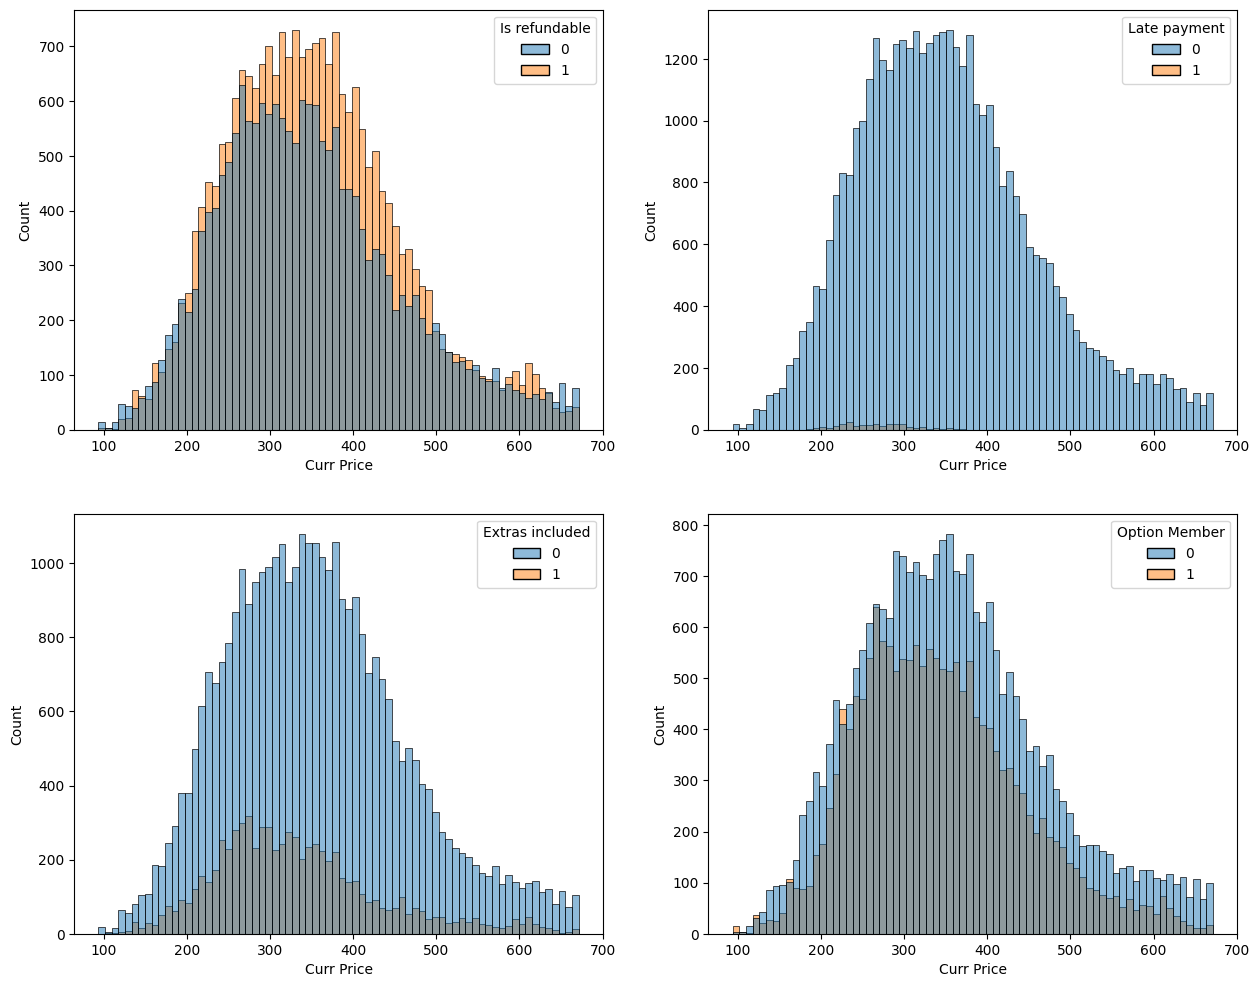

In [39]:
fig,axes = plt.subplots(2,2,figsize=(15,12))
for col,ax in zip(expedia_df.columns[10:],axes.flatten()):
    sns.histplot(data=expedia_df,x='Curr Price',ax=ax,hue = col)

מכאן ניתן להסיק שאין הבדל בהתפלגות המחירים בין הקטגוריות של העמודות הנ"ל , לכן העמודות יהיו פחות רלוונטיות כשמדובר במודלים כמו עץ/רנדום פורסט 

count         mean         std   min    25%     50%  \
Grade                42111.0     8.318147    0.724829   5.5    8.0     8.4   
Num of Reviews       42111.0  1067.369286  662.631464   0.0  998.0  1003.0   
Curr Price           42111.0   351.212379  106.608677  93.7  273.0   340.5   
Original Price       42111.0   381.314212  129.883768  93.7  290.8   362.7   
Percent of discount  42111.0     0.066559    0.087376   0.0    0.0     0.0   

                         75%      max  
Grade                   8.80    10.00  
Num of Reviews       1156.00  6080.00  
Curr Price            413.90   671.40  
Original Price        449.30  1357.70  
Percent of discount     0.13     0.51

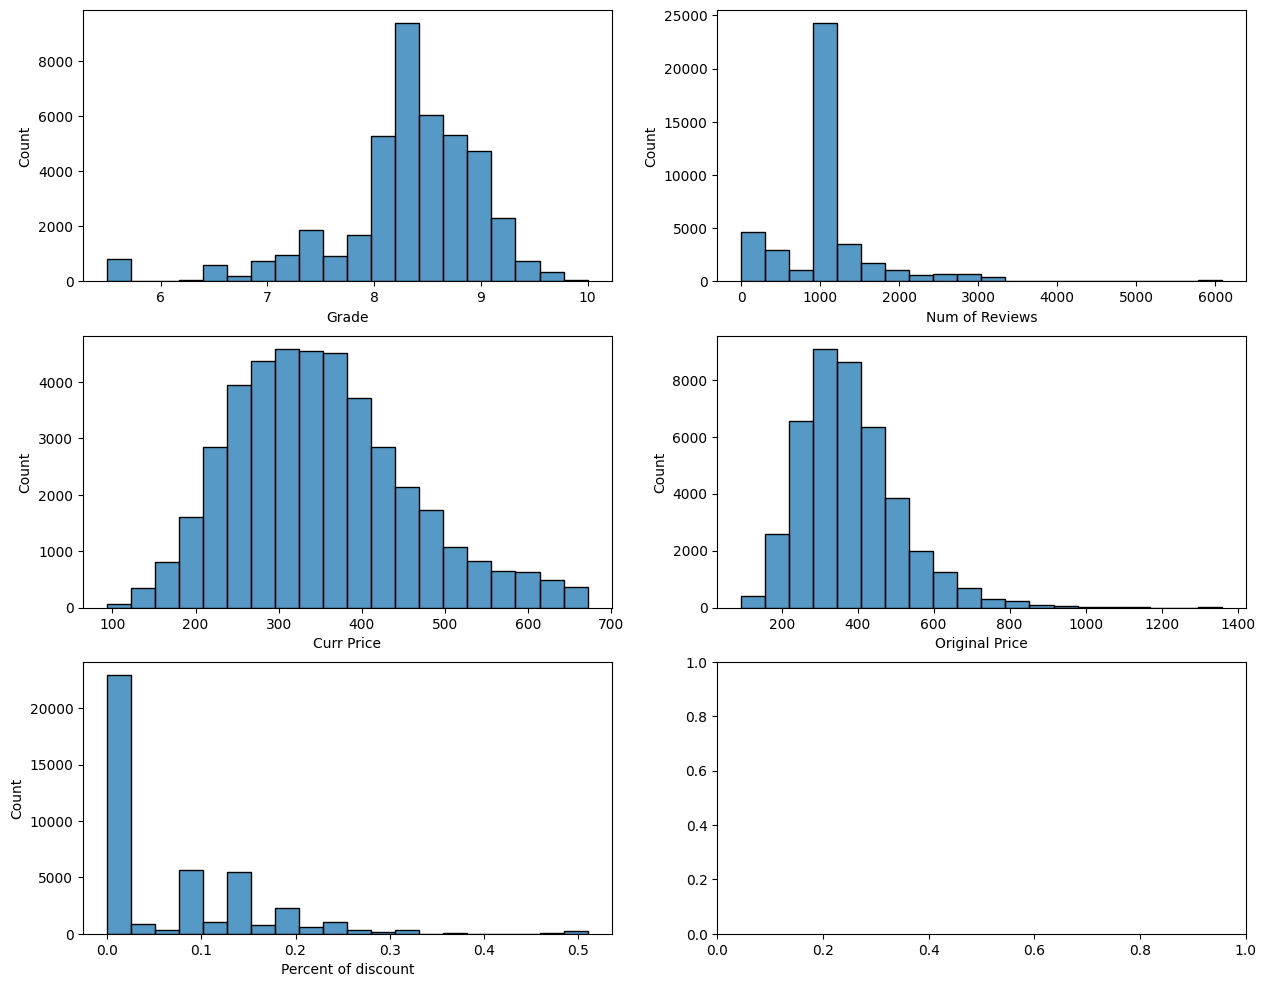

In [40]:
cols = expedia_df.columns[5:10]
fig,axes = plt.subplots(3,2,figsize=(15,12))
for col,ax in zip(cols,axes.flatten()):
    sns.histplot(data=expedia_df,x=col,ax=ax, bins=20)
    
expedia_df[cols].describe().T

לגבי עמודות המחירים - ניתן לראות שבמידה ונוריד את הערכים החריגים נקבל התפלגות די נורמאלית
לגבי אחוזי ההנחה - ניתן לראות שיותר מחצי מהמלונות ללא הנחה
לגבי ציוני המלונות - ניתן לראות שעיקר המלונות הם בין ציון 8 ל9
לגבי מספר התגובות - רוב המלונות עם כ1000 תגובות

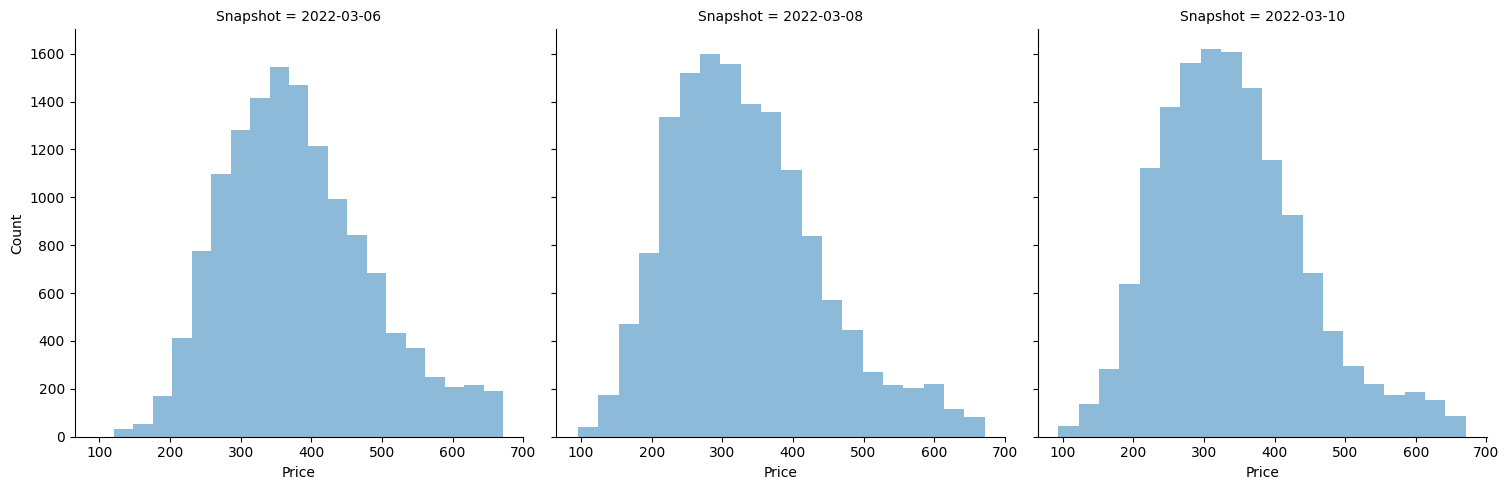

count        mean         std    min    25%    50%    75%    max
Snapshot                                                                      
2022-03-06  13655.0  380.753958  103.706898  120.6  304.6  369.4  444.1  671.4
2022-03-08  14295.0  333.612718  106.347612   95.8  256.0  320.2  395.4  671.3
2022-03-10  14161.0  340.492578  103.645614   93.7  265.6  329.6  401.2  670.6

In [41]:
# Create a FacetGrid with three histograms
g = sns.FacetGrid(expedia_df, col='Snapshot', height=5, aspect=1)
g = g.map(plt.hist, 'Curr Price', alpha=0.5, bins=20)

# Add labels to the plot
g.set_axis_labels('Price', 'Count')
plt.show()

expedia_df.groupby('Snapshot')['Curr Price'].describe()


למרות שהתאריך הראשון בעל ממוצע וחציון יותר גבוהים במחירים, ניתן להסיק כי אין הבדל משמעותי בין שלושת התאריכים ומכאן שלא תהיה משמעות להפוך את העמודה לאורדינאלית

In [42]:
expedia_df.replace({'Snapshot': {pd.datetime(2022,3,6).date() : 'Monday', pd.datetime(2022,3,8).date() : 'Wednesday', pd.datetime(2022,3,10).date() : 'Friday'}}, inplace=True)

In [43]:
expedia_df = expedia_df.join(pd.get_dummies(expedia_df['Snapshot']))


In [44]:
expedia_df.columns

Index(['Snapshot', 'Index', 'Hotel Name', 'TTT', 'LOS', 'Grade',
       'Num of Reviews', 'Curr Price', 'Original Price', 'Percent of discount',
       'Is refundable', 'Late payment', 'Extras included', 'Option Member',
       'Friday', 'Monday', 'Wednesday'],
      dtype='object')

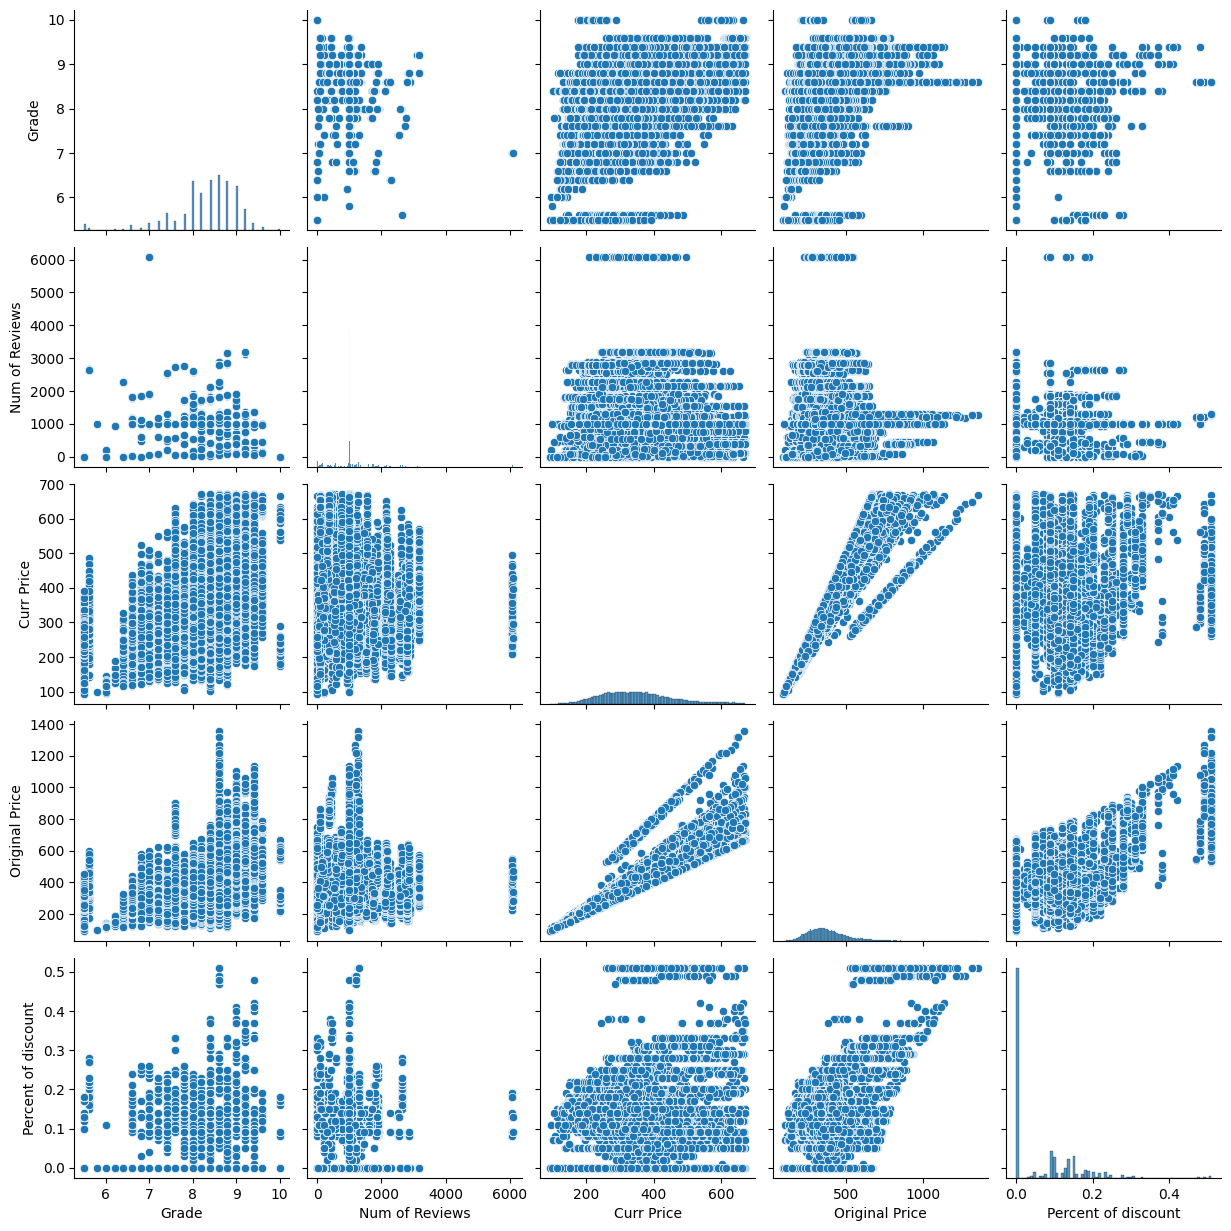

In [45]:
sns.pairplot(expedia_df.iloc[:,5:10])

<Axes: xlabel='TTT', ylabel='Curr Price'>

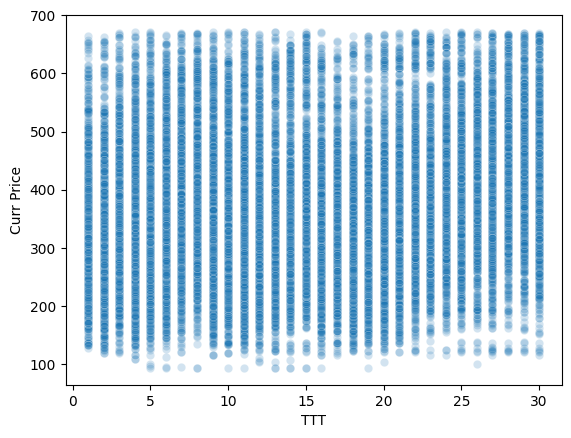

In [46]:
sns.scatterplot(data =expedia_df, x = 'TTT', y = 'Curr Price', alpha = 0.2)

העמודה לא ממש יוצרת הבדל במחירים, ככל שהימים שנותרו להזמנה קטנים יותר ניתן לראות יותר מלונות עם מחירים חריגים וגבוהים אבל אי אפשר להגדיר את זה כתבנית של הנתונים

count        mean         std   min     25%     50%    75%    max
LOS                                                                    
1    8476.0  336.482150  111.339989  94.2  251.60  323.50  404.4  671.0
2    8486.0  355.249776  109.168383  93.7  273.25  342.10  423.2  671.0
3    8390.0  355.757044  107.234879  93.8  277.00  344.30  418.2  671.4
4    8347.0  355.464107  103.733920  93.7  279.80  344.30  414.8  670.6
5    8412.0  353.230112   99.816510  93.8  281.40  345.65  410.6  669.0

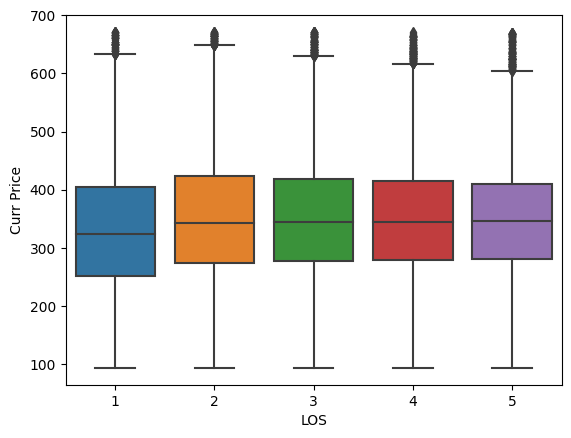

In [47]:
sns.boxplot(data =expedia_df, x = 'LOS', y = 'Curr Price')
expedia_df.groupby('LOS')['Curr Price'].describe()

כמות הלילות של ההזמנה לא משפיעה על המחיר ללילה של המלון

<Axes: xlabel='Index', ylabel='Curr Price'>

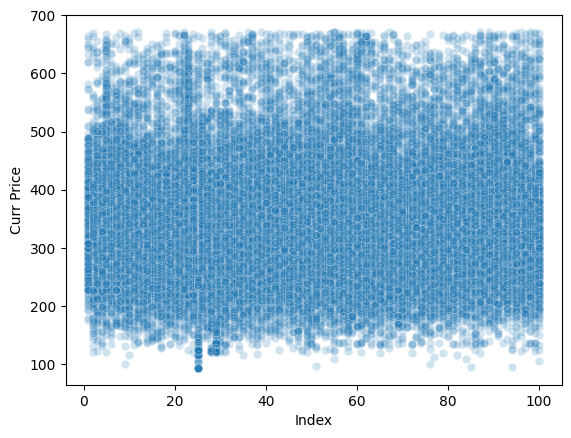

In [48]:
sns.scatterplot(data =expedia_df, x = 'Index', y = 'Curr Price', alpha = 0.2)

ניתן לראות שבדרך כלל במקומות הראשונים לא מוצגים המלונות היקרים

<Axes: xlabel='Num of Reviews', ylabel='Curr Price'>

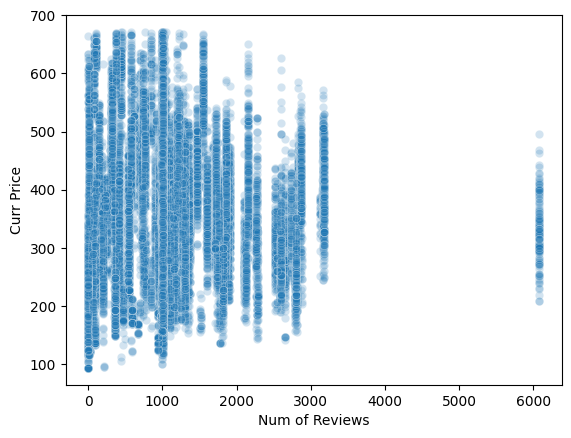

In [49]:
sns.scatterplot(data =expedia_df, x = 'Num of Reviews', y = 'Curr Price', alpha = 0.2)

רוב המלונות היקרים עם פחות תגובות מהממוצע - 1000 תגובות

<Axes: xlabel='Percent of discount', ylabel='Curr Price'>

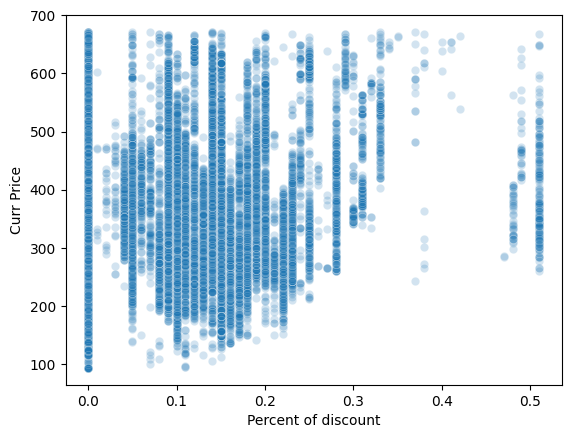

In [50]:
sns.scatterplot(data =expedia_df, x = 'Percent of discount', y = 'Curr Price', alpha = 0.2)

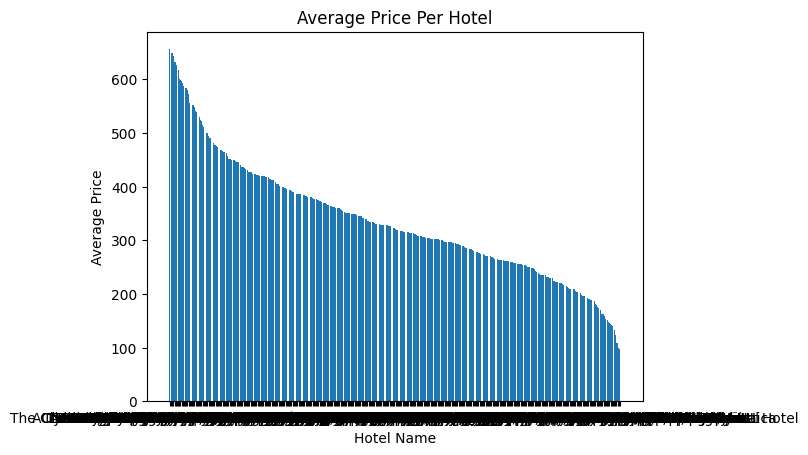

In [51]:
# Group data by hotel name and calculate mean price
avg_price_df = expedia_df.groupby('Hotel Name')['Curr Price'].mean()

# Sort by count of hotels
avg_price_df = avg_price_df.sort_values(ascending=False)

# Create bar graph of average price per hotel
plt.bar(avg_price_df.index, avg_price_df.values)
plt.xlabel('Hotel Name')
plt.ylabel('Average Price')
plt.title('Average Price Per Hotel')
plt.show()

<Axes: >

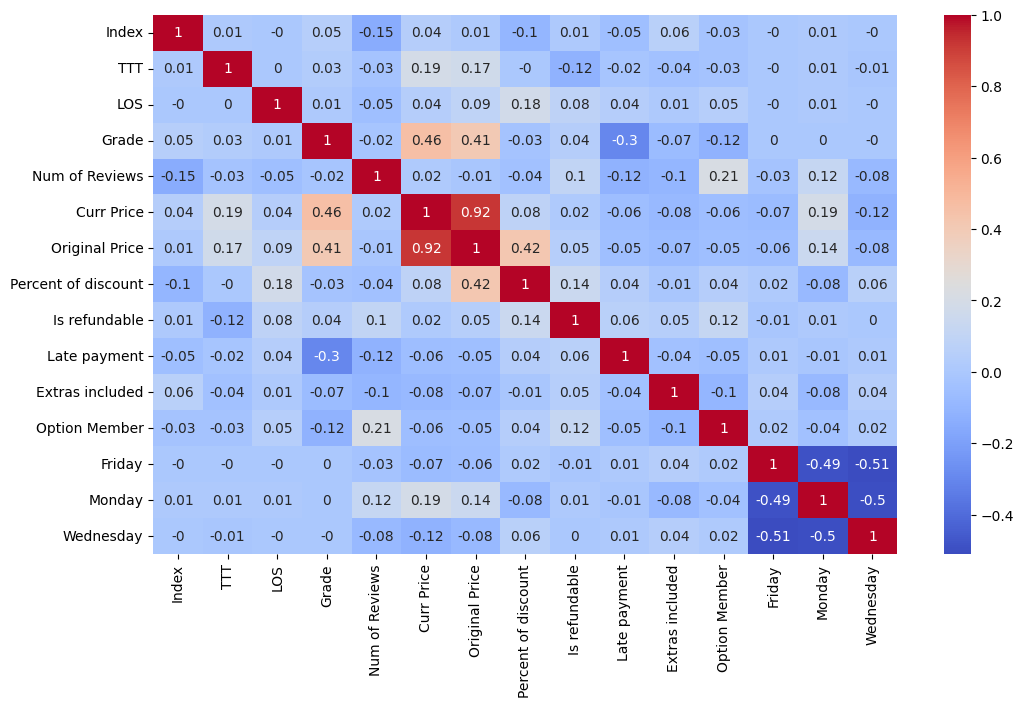

In [52]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(expedia_df.corr().round(2), annot=True, ax=ax, cmap='coolwarm')

In [53]:
expedia_df.corr()['Curr Price'].sort_values(ascending=False)


Curr Price             1.000000
Original Price         0.923155
Grade                  0.457403
Monday                 0.191958
TTT                    0.191444
Percent of discount    0.077346
LOS                    0.044828
Index                  0.044578
Is refundable          0.018732
Num of Reviews         0.016228
Late payment          -0.062936
Option Member         -0.064408
Friday                -0.071574
Extras included       -0.081251
Wednesday             -0.118348
Name: Curr Price, dtype: float64

ניתן לראות שלציון המלון יש קורלציה גבוהה יחסית לשאר עם המחיר של המלון, לכן כדאי לדאוג שהדאתא של הלמידה ושל האימון יהיו מאוזנים ביחס לציון של המלונות

<Axes: xlabel='Grade', ylabel='Count'>

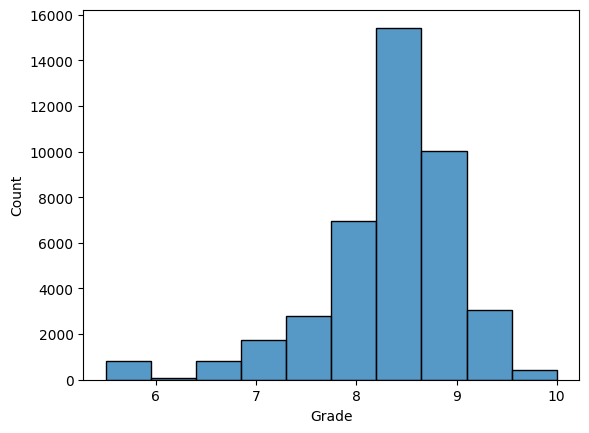

In [54]:
sns.histplot(data =expedia_df, x = 'Grade', bins=10)

ניתן לפצל את הדאתא לבינים לפי ההיסטוגרמה הנ"ל

<Axes: xlabel='Grade_cat', ylabel='Count'>

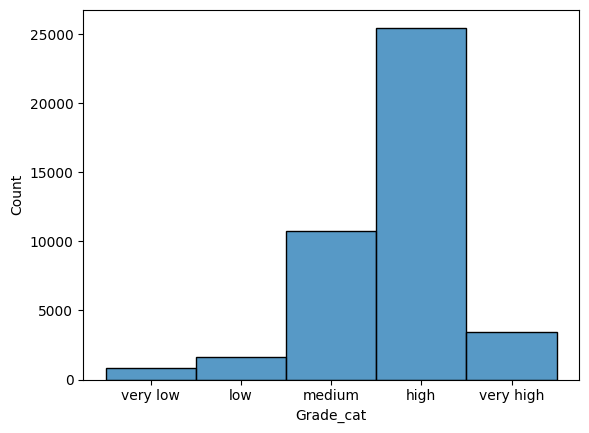

In [55]:
expedia_df['Grade_cat'] = pd.cut(expedia_df['Grade'], bins=[5,6,7, 8, 9,10], labels=['very low', 'low','medium', 'high', 'very high'])
sns.histplot(data =expedia_df, x = 'Grade_cat', bins=5)

In [57]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(expedia_df, expedia_df['Grade_cat']):
    strat_train_set = expedia_df.loc[train_index]
    strat_test_set = expedia_df.loc[test_index]

In [58]:
strat_test_set["Grade_cat"].value_counts() / len(strat_test_set)


high         0.604797
medium       0.254551
very high    0.082080
low          0.038468
very low     0.020104
Name: Grade_cat, dtype: float64

In [59]:
expedia_df["Grade_cat"].value_counts() / len(expedia_df)


high         0.604759
medium       0.254565
very high    0.082116
low          0.038494
very low     0.020066
Name: Grade_cat, dtype: float64

דאגנו לכך שהחלק יחסי של קטגוריית ציון יהיה שווה גם באימון וגם בלמידה

In [60]:
for set_ in (expedia_df, strat_train_set, strat_test_set):
    set_.drop('Grade_cat', axis = 1, inplace = True)

In [2]:
# Desicion tree regressor

In [143]:
expedia_df.head()

Snapshot  Index                         Hotel Name  TTT  LOS  Grade  \
0   Monday      1                        Hotel 32 32    1    1    8.0   
1   Monday      2  Sonesta Simply Suites Jersey City    1    1    8.4   
2   Monday      3                 Park Lane New York    1    1    8.8   
3   Monday      4                       Arlo Midtown    1    1    9.2   
4   Monday      5      PUBLIC, an Ian Schrager hotel    1    1    8.0   

   Num of Reviews  Curr Price  Original Price  Percent of discount  \
0          1296.0       303.8           393.4                 0.23   
1          1002.0       237.2           237.2                 0.00   
2           305.0       490.7           538.8                 0.09   
3          3123.0       358.5           358.5                 0.00   
4          1465.0       467.8           467.8                 0.00   

   Is refundable  Late payment  Extras included  Option Member  Friday  \
0              0             0                0              0       0   
1              1             0                0              0       0   
2              0             0                0              0       0   
3              1             0                0              1       0   
4              0             0                0              1       0   

   Monday  Wednesday  Grade_cat  
0       1          0     medium  
1       1          0       high  
2       1          0       high  
3       1          0  very high  
4       1          0     medium

# booking cleaning

In [63]:
booking_df = pd.read_csv(r"C:\Users\yarin\Data Science - College Of Management\Year 2\Semester 2\Data Science Fundementals\Final Project\DSF-final project\Notebooks\Booking\Booking_hotels.csv")


In [64]:
booking_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Snapshot              45000 non-null  object 
 1   Index                 45000 non-null  int64  
 2   Hotel Name            45000 non-null  object 
 3   TTT                   45000 non-null  int64  
 4   LOS                   45000 non-null  int64  
 5   Grade                 45000 non-null  float64
 6   Num of Reviews        45000 non-null  object 
 7   Curr Price            45000 non-null  object 
 8   Original Price        45000 non-null  object 
 9   Distance from center  45000 non-null  object 
 10  Type of room          45000 non-null  object 
 11  Location grade        20488 non-null  object 
 12  Extra Data            45000 non-null  object 
dtypes: float64(1), int64(3), object(9)
memory usage: 4.5+ MB


In [65]:
booking_df.head()


Snapshot  Index                          Hotel Name  TTT  \
0  2023-03-06 11:24:01.241227      1  Margaritaville Resort Times Square    1   
1  2023-03-06 11:24:01.241227      2           33 Seaport Hotel New York    1   
2  2023-03-06 11:24:01.241227      3                 The Belvedere Hotel    1   
3  2023-03-06 11:24:01.241227      4                      CIVILIAN Hotel    1   
4  2023-03-06 11:24:01.241227      5     The Cloud One New York-Downtown    1   

   LOS  Grade Num of Reviews                Curr Price  \
0    1    8.8  1,369 reviews                     ₪ 752   
1    1    8.6    284 reviews  ₪ 1,050\r\nPrice ₪ 1,050   
2    1    8.0  3,644 reviews                     ₪ 510   
3    1    8.5  1,172 reviews                     ₪ 767   
4    1    8.2    518 reviews                     ₪ 620   

             Original Price Distance from center             Type of room  \
0                     ₪ 752   1.5 km from center      Standard Queen Room   
1  ₪ 1,050\r\nPrice ₪ 1,050   6.9 km from center  Superior Courtyard King   
2                     ₪ 510   0.9 km from center       Standard King Room   
3                     ₪ 767   0.9 km from center              Double Room   
4                     ₪ 620     7 km from center       Standard King Room   

  Location grade                                         Extra Data  
0   Location 9.4  Standard Queen Room\r\n1 queen bed\r\nOnly 1 r...  
1            NaN              Superior Courtyard King\r\n1 king bed  
2   Location 9.4  Standard King Room\r\n1 king bed\r\nOnly 2 roo...  
3   Location 9.5                         Double Room\r\n1 queen bed  
4            NaN  Standard King Room\r\n1 king bed\r\nFREE cance...

In [66]:
# extracting numeric data and removing useless text from prices, location grade, and review. normalize distance from center to m' instead of km, and inserts -1 instead of NaNs

#booking_df = pd.read_csv(r"C:\Users\royzo\DS-project\Notebooks\Booking\Booking_hotels.csv")
booking_df[['del', 'Curr Price']] = booking_df['Curr Price'].str.split(' ', 1, expand = True)
booking_df[['Curr Price','del2']] = booking_df['Curr Price'].str.split(r"\r", 0, expand = True)
booking_df[['del', 'Original Price']] = booking_df['Original Price'].str.split(' ', 1, expand = True)
booking_df[['Original Price','del2']] = booking_df['Original Price'].str.split(r"\r", 0, expand = True)
booking_df[['Num of Reviews', 'del']] = booking_df['Num of Reviews'].str.split(' ', 1, expand = True)
booking_df['Num of Reviews'] = booking_df['Num of Reviews'].apply(lambda x: int(float(x.replace(',',''))))


booking_df['Distance from center'] = booking_df['Distance from center'].apply(lambda a: int(float(a.split(' ')[0])*1000) if a.split(' ')[1] == 'km' else int(a.split(' ')[0]))
booking_df[['del', 'Location grade']] = booking_df['Location grade'].str.split(' ', 1, expand = True)
booking_df['Location grade'] = booking_df['Location grade'].apply(lambda a: -1 if pd.isna(a) else a)
booking_df["Location grade"] = booking_df["Location grade"].apply(lambda a: float(a))

booking_df = booking_df.drop(columns=['del', 'del2'])

In [67]:
# from datetime to date

booking_df['Snapshot'] = pd.to_datetime(booking_df['Snapshot']).dt.date
booking_df

Snapshot  Index                                         Hotel Name  \
0      2023-03-06      1                 Margaritaville Resort Times Square   
1      2023-03-06      2                          33 Seaport Hotel New York   
2      2023-03-06      3                                The Belvedere Hotel   
3      2023-03-06      4                                     CIVILIAN Hotel   
4      2023-03-06      5                    The Cloud One New York-Downtown   
...           ...    ...                                                ...   
44995  2023-03-10     96      Aloft Manhattan Downtown - Financial District   
44996  2023-03-10     97  Hampton Inn Manhattan/Downtown- Financial Dist...   
44997  2023-03-10     98                                     Leon Hotel LES   
44998  2023-03-10     99                                            SoHo 54   
44999  2023-03-10    100                          New York Marriott Marquis   

       TTT  LOS  Grade  Num of Reviews Curr Price Original Price  \
0        1    1    8.8            1369        752            752   
1        1    1    8.6             284      1,050          1,050   
2        1    1    8.0            3644        510            510   
3        1    1    8.5            1172        767            767   
4        1    1    8.2             518        620            620   
...    ...  ...    ...             ...        ...            ...   
44995   30    5    7.5            1106      3,841          3,841   
44996   30    5    7.6             658      4,459          4,459   
44997   30    5    8.1            1309      5,398          6,748   
44998   30    5    6.9            1562      3,840          4,266   
44999   30    5    8.2            1712      7,115          7,115   

       Distance from center                                    Type of room  \
0                      1500                             Standard Queen Room   
1                      6900                         Superior Courtyard King   
2                       900                              Standard King Room   
3                       900                                     Double Room   
4                      7000                              Standard King Room   
...                     ...                                             ...   
44995                  6800                             Guest room, 1 Queen   
44996                  7700                                      Queen Room   
44997                  5900                             Superior Queen Room   
44998                  5300                                       SoHo King   
44999                  1100  Renovated Deluxe, Guest room, 1 King, Sofa bed   

       Location grade                                         Extra Data  
0                 9.4  Standard Queen Room\r\n1 queen bed\r\nOnly 1 r...  
1                -1.0              Superior Courtyard King\r\n1 king bed  
2                 9.4  Standard King Room\r\n1 king bed\r\nOnly 2 roo...  
3                 9.5                         Double Room\r\n1 queen bed  
4                -1.0  Standard King Room\r\n1 king bed\r\nFREE cance...  
...               ...                                                ...  
44995            -1.0  Guest room, 1 Queen\r\n1 queen bed\r\nFree can...  
44996            -1.0  Queen Room\r\n1 queen bed\r\nFREE cancellation...  
44997            -1.0  Superior Queen Room\r\n1 queen bed\r\nFREE can...  
44998            -1.0  SoHo King\r\n1 king bed\r\nFREE cancellation •...  
44999             9.5  Renovated Deluxe, Guest room, 1 King, Sofa bed...  

[45000 rows x 13 columns]

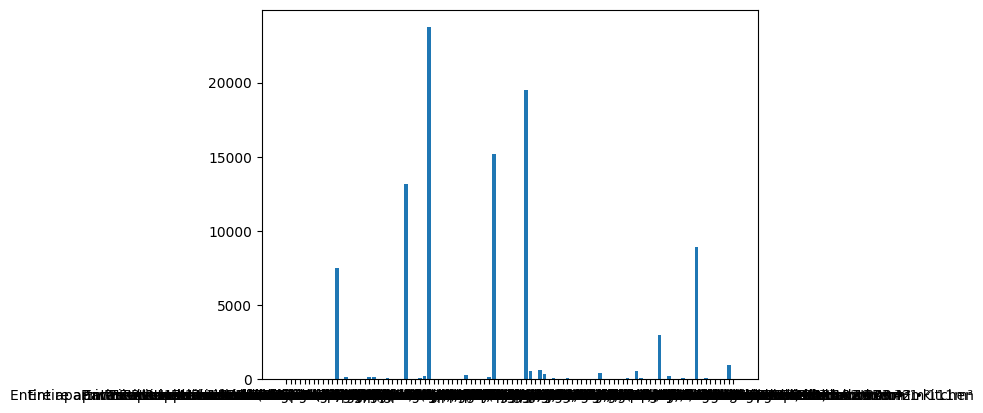

In [68]:
#breaking down 'Extra Data' to categories

op_set = set()
#row = df.head(1)
for index, row in booking_df.iterrows():
    line_list = row['Extra Data'].split('\r\n')[1:-1]
    for item in line_list:
        op_set.add(item)

op_list = []
for index, row in booking_df.iterrows():
    line_list = row['Extra Data'].split('\r\n')[1:-1]
    for item in line_list:
        op_list.append(item)

op_dict = {}
for set_item in op_set:
    count = 0
    for list_item in op_list:
        if list_item == set_item:
            count = count + 1
            
    op_dict[set_item] = count 

names = list(op_dict.keys())
values = list(op_dict.values())

plt.bar(range(len(op_dict)), values, tick_label=names)
plt.show()

In [70]:
# focusing on top categories, ignoring bed count and other generic cats
sorted(op_dict.items(), key=lambda x: x[1], reverse=True)

[('FREE cancellation • No prepayment needed', 23734),
 ('1 king bed', 19514),
 ('You can cancel later, so lock in this great price today!', 15192),
 ('1 queen bed', 13172),
 ('Breakfast included', 8929),
 ('Free cancellation', 7520),
 ('1 full bed', 2975),
 ('2 full beds', 972),
 ('Private suite', 599),
 ('2 beds (1 king, 1 sofa bed)', 560),
 ('1 bunk bed', 558),
 ('2 twin beds', 455),
 ('2 queen beds', 354),
 ('Entire studio • 1 bathroom • 19m²', 317),
 ('Entire studio • 1 bathroom • 25m²', 239),
 ('2 beds (1 sofa bed, 1 queen)', 216),
 ('Entire studio • 1 bathroom • 325m²', 172),
 ('Entire studio • 1 bathroom • 18m²', 166),
 ('Entire studio • 1 bathroom • 20m²', 160),
 ('Private suite • 1 bedroom • 1 living room • 1 bathroom • 28m²', 138),
 ('1 twin bed', 115),
 ('Entire studio • 1 bathroom • 28m²', 96),
 ('Entire studio • 1 bathroom • 29m²', 65),
 ('Beds: 1 double or 2 twins', 64),
 ('Private suite • 1 bedroom • 1 living room • 1 bathroom • 30m²', 63),
 ('4 twin beds', 62),
 ('Entir

In [71]:
# combining cats for free cancelation and comparing counts
cancellation_count = 0
for index, row in booking_df.iterrows():
    line_list = row['Extra Data'].split('\r\n')[1:-1]
    if ('FREE cancellation • No prepayment needed' in line_list) or ('Free cancellation' in line_list):
        cancellation_count = cancellation_count + 1
        
print(cancellation_count)

booking_df['Free Cancellation'] = booking_df['Extra Data'].apply(lambda a: 1 if 
                                                 ('FREE cancellation • No prepayment needed' in a.split('\r\n')) 
                                                 or ('Free cancellation' in a.split('\r\n')) else 0)
booking_df.groupby('Free Cancellation').count()

31254


Snapshot  Index  Hotel Name    TTT    LOS  Grade  \
Free Cancellation                                                     
0                     13746  13746       13746  13746  13746  13746   
1                     31254  31254       31254  31254  31254  31254   

                   Num of Reviews  Curr Price  Original Price  \
Free Cancellation                                               
0                           13746       13746           13746   
1                           31254       31254           31254   

                   Distance from center  Type of room  Location grade  \
Free Cancellation                                                       
0                                 13746         13746           13746   
1                                 31254         31254           31254   

                   Extra Data  
Free Cancellation              
0                       13746  
1                       31254

In [72]:
# converting top categories to bool

booking_df['No prepayment needed'] = booking_df['Extra Data'].apply(lambda a: 1 if 
                                                 ('FREE cancellation • No prepayment needed' in a.split('\r\n')) else 0)
booking_df['Breakfast included'] = booking_df['Extra Data'].apply(lambda a: 1 if 
                                                 ('Breakfast included' in a.split('\r\n')) else 0)
booking_df['Cancel Later'] = booking_df['Extra Data'].apply(lambda a: 1 if 
                                                 ('You can cancel later, so lock in this great price today!' in a.split('\r\n')) else 0)
booking_df = booking_df.drop(columns=['Extra Data'])

In [73]:
#converting ILS to USD for comparison to expedia
c = CurrencyRates()
x = booking_df['Snapshot'].unique()
curr_dict = {}
for date in x:
    curr_dict[date] = c.get_rate('ILS','USD', date)
    print(curr_dict[date])


0.27958937198067635
0.27958937198067635
0.27958937198067635


In [74]:
booking_df['Original Price'] = booking_df['Original Price'].apply(lambda x: int(x.replace(',','')))
booking_df['Curr Price'] = booking_df['Curr Price'].apply(lambda x: int(x.replace(',','')))

In [75]:
booking_df['Original Price'] = booking_df.apply(lambda x: (x['Original Price']*curr_dict[x['Snapshot']])/x['LOS']  , axis = 1)
booking_df['Curr Price'] = booking_df.apply(lambda x: (x['Curr Price']*curr_dict[x['Snapshot']])/x['LOS']  , axis = 1)

In [76]:
booking_df['Original Price'] = booking_df['Original Price'].apply(lambda x: round(x,2))
booking_df['Curr Price'] = booking_df['Curr Price'].apply(lambda x: round(x,2))

In [77]:
room_type = booking_df['Type of room'].unique()
print(room_type)
len(room_type)


['Standard Queen Room' 'Superior Courtyard King' 'Standard King Room'
 'Double Room' 'Deluxe King Room' 'Classic Room'
 'Renovated Deluxe, Guest room, 2 Double' 'King Room'
 'Executive Queen Suite with Sofa Bed'
 'Efficiency King Studio with Sofa Bed' 'Bunk Pod' 'Deluxe Family King'
 'Queen Garden Room' 'Newly Renovated Standard Queen Room' 'Queen Room'
 'Superior Double or Twin Room' 'Social City View Doubles' 'Standard Room'
 'King Room with City View' 'Queen Studio with Balcony'
 'Classic King Guest Room' 'Run of House' 'King Room - Disability Access'
 'Premium King Room with City View' 'Single Room' 'Superior Queen Room'
 'Deluxe Queen Room with Gotham View - Non-Smoking'
 'King Room - Disability Access/Shower'
 'Classic Double Room with Two Double Beds' 'Superior King Room'
 'King Room with Balcony' "Three's Company" 'Deluxe Two Queen Beds'
 'Standard Room with Queen Bed - Non-Smoking' 'Small Queen Room'
 'Double Room with Two Double Beds and Shower - Accessible'
 'Premier Two Dou

685

In [78]:
booking_df.head(600)

Snapshot  Index                                         Hotel Name  \
0    2023-03-06      1                 Margaritaville Resort Times Square   
1    2023-03-06      2                          33 Seaport Hotel New York   
2    2023-03-06      3                                The Belvedere Hotel   
3    2023-03-06      4                                     CIVILIAN Hotel   
4    2023-03-06      5                    The Cloud One New York-Downtown   
..          ...    ...                                                ...   
595  2023-03-06     96  Holiday Inn Express New York City Chelsea, an ...   
596  2023-03-06     97                          LUMA Hotel - Times Square   
597  2023-03-06     98  Embassy Suites By Hilton New York Manhattan Ti...   
598  2023-03-06     99                       Millennium Downtown New York   
599  2023-03-06    100  Fairfield Inn & Suites By Marriott New York Ma...   

     TTT  LOS  Grade  Num of Reviews  Curr Price  Original Price  \
0      1    1    8.8            1369      210.25          210.25   
1      1    1    8.6             284      293.57          293.57   
2      1    1    8.0            3644      142.59          142.59   
3      1    1    8.5            1172      214.45          214.45   
4      1    1    8.2             518      173.35          173.35   
..   ...  ...    ...             ...         ...             ...   
595    2    1    7.9            3013      224.79          224.79   
596    2    1    9.0            2108      364.30          364.30   
597    2    1    7.9            4111      306.71          306.71   
598    2    1    7.4            3596      265.61          265.61   
599    2    1    7.6            4579      286.30          286.30   

     Distance from center                                       Type of room  \
0                    1500                                Standard Queen Room   
1                    6900                            Superior Courtyard King   
2                     900                                 Standard King Room   
3                     900                                        Double Room   
4                    7000                                 Standard King Room   
..                    ...                                                ...   
595                  2400                                          King Room   
596                  1500  Metro King Room with Roll-In Shower - Disabili...   
597                  1900                        1 King Bed Studio with Sofa   
598                  6800                                 Superior King Room   
599                  1600                    Accessible, Guest room, 1 Queen   

     Location grade  Free Cancellation  No prepayment needed  \
0               9.4                  0                     0   
1              -1.0                  0                     0   
2               9.4                  0                     0   
3               9.5                  0                     0   
4              -1.0                  1                     1   
..              ...                ...                   ...   
595            -1.0                  0                     0   
596             9.7                  0                     0   
597             9.3                  1                     1   
598            -1.0                  1                     1   
599            -1.0                  0                     0   

     Breakfast included  Cancel Later  
0                     0             0  
1                     0             0  
2                     0             0  
3                     0             0  
4                     0             1  
..                  ...           ...  
595                   1             0  
596                   0             0  
597                   1             1  
598                   0             1  
599                   1             0  

[600 rows x 16 columns]

In [79]:
booking_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Snapshot              45000 non-null  object 
 1   Index                 45000 non-null  int64  
 2   Hotel Name            45000 non-null  object 
 3   TTT                   45000 non-null  int64  
 4   LOS                   45000 non-null  int64  
 5   Grade                 45000 non-null  float64
 6   Num of Reviews        45000 non-null  int64  
 7   Curr Price            45000 non-null  float64
 8   Original Price        45000 non-null  float64
 9   Distance from center  45000 non-null  int64  
 10  Type of room          45000 non-null  object 
 11  Location grade        45000 non-null  float64
 12  Free Cancellation     45000 non-null  int64  
 13  No prepayment needed  45000 non-null  int64  
 14  Breakfast included    45000 non-null  int64  
 15  Cancel Later       

# booking EDA

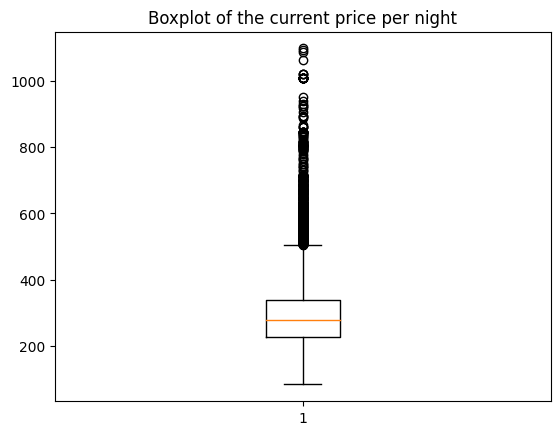

In [80]:
plt.boxplot(booking_df['Curr Price'])
plt.title('Boxplot of the current price per night')
plt.show()

In [81]:
q1 = booking_df['Curr Price'].quantile(0.25)
q3 = booking_df['Curr Price'].quantile(0.75)
iqr = q3-q1
top_lim = q3 + 1.5*iqr
bottom_lim = q1 - 1.5* iqr
booking_df = booking_df.drop(booking_df[booking_df['Curr Price'] > top_lim].index)
booking_df = booking_df.drop(booking_df[booking_df['Curr Price'] < bottom_lim].index)

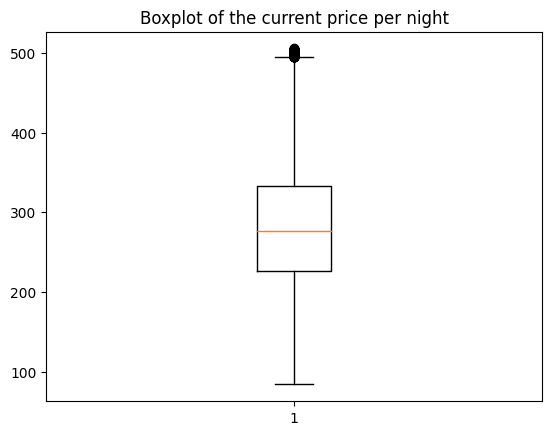

In [82]:
plt.boxplot(booking_df['Curr Price'])
plt.title('Boxplot of the current price per night')
plt.show()

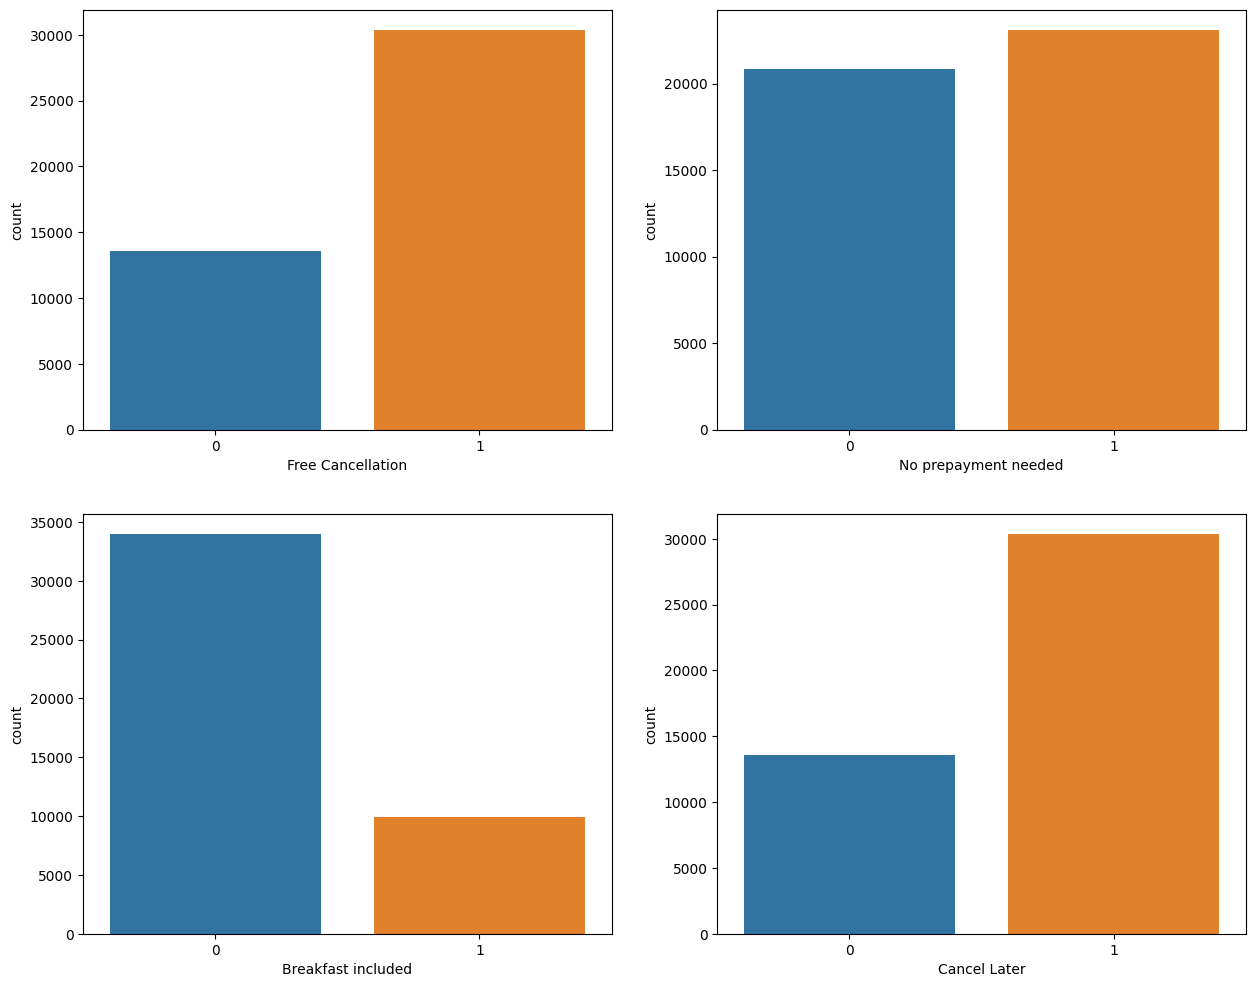

In [83]:
fig,axes = plt.subplots(2,2,figsize=(15,12))
for col,ax in zip(booking_df.columns[12:],axes.flatten()):
    sns.countplot(data=booking_df,x=col,ax=ax)

Free Cancellation mean: true  - false =  16.106387941893217
No prepayment needed mean: true  - false =  14.980615225513702
Breakfast included mean: true  - false =  -2.8764301696223242
Cancel Later mean: true  - false =  16.106387941893217


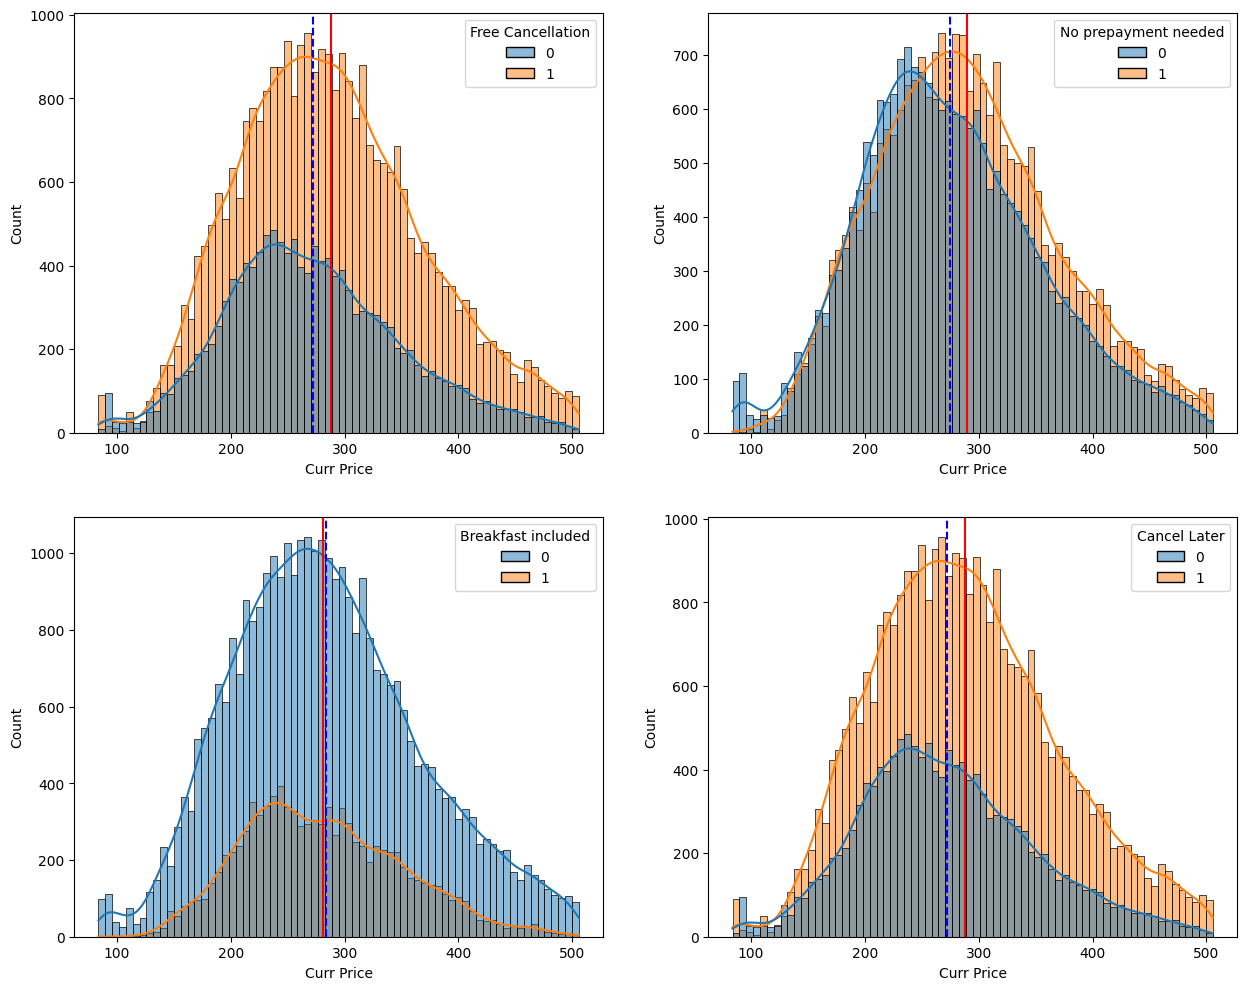

In [84]:
fig,axes = plt.subplots(2,2,figsize=(15,12))
for col,ax in zip(booking_df.columns[12:],axes.flatten()):
    sns.histplot(data=booking_df,x='Curr Price',ax=ax,hue = col ,kde =True)
    mean_1 =booking_df.loc[booking_df[col]==1, "Curr Price"].mean()
    ax.axvline(mean_1,c = 'r' , ls = '-')
    mean_0 =booking_df.loc[booking_df[col]==0, "Curr Price"].mean()
    ax.axvline(mean_0,c = 'b' , ls = '--' )
    print(col ,"mean: true  - false = " ,mean_1-mean_0 )

ניתן לראות שהממוצע יהיה יותר גדול משמע מחיר יותר יקר כאשר קיימים אחד מהפירים האלה:ביטול מאוחר, ביטול בחינם ותשלום מאוחר 

3combine  mean: true  - false =  14.980615225513702


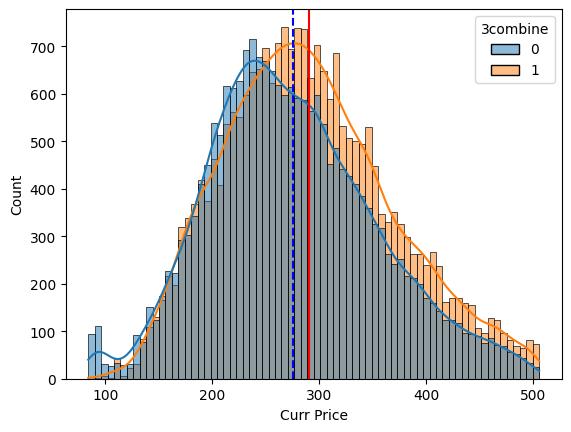

In [85]:

booking_df['3combine'] = booking_df['Free Cancellation'] +booking_df['No prepayment needed'] +booking_df['Cancel Later'] 
booking_df['3combine'] = booking_df['3combine'].apply(lambda x: 1 if x==3 else 0)
sns.histplot(data=booking_df,x='Curr Price',hue = '3combine' ,kde =True)
mean_1 =booking_df.loc[booking_df['3combine']==1, "Curr Price"].mean()
plt.axvline(mean_1,c = 'r' , ls = '-')
mean_0 =booking_df.loc[booking_df['3combine']==0, "Curr Price"].mean()
plt.axvline(mean_0,c = 'b' , ls = '--' )
booking_df.drop('3combine' , inplace = True ,axis =1)
print('3combine' ," mean: true  - false = " ,mean_1-mean_0 )

In [86]:
booking_df

Snapshot  Index                                         Hotel Name  \
0      2023-03-06      1                 Margaritaville Resort Times Square   
1      2023-03-06      2                          33 Seaport Hotel New York   
2      2023-03-06      3                                The Belvedere Hotel   
3      2023-03-06      4                                     CIVILIAN Hotel   
4      2023-03-06      5                    The Cloud One New York-Downtown   
...           ...    ...                                                ...   
44995  2023-03-10     96      Aloft Manhattan Downtown - Financial District   
44996  2023-03-10     97  Hampton Inn Manhattan/Downtown- Financial Dist...   
44997  2023-03-10     98                                     Leon Hotel LES   
44998  2023-03-10     99                                            SoHo 54   
44999  2023-03-10    100                          New York Marriott Marquis   

       TTT  LOS  Grade  Num of Reviews  Curr Price  Original Price  \
0        1    1    8.8            1369      210.25          210.25   
1        1    1    8.6             284      293.57          293.57   
2        1    1    8.0            3644      142.59          142.59   
3        1    1    8.5            1172      214.45          214.45   
4        1    1    8.2             518      173.35          173.35   
...    ...  ...    ...             ...         ...             ...   
44995   30    5    7.5            1106      214.78          214.78   
44996   30    5    7.6             658      249.34          249.34   
44997   30    5    8.1            1309      301.84          377.33   
44998   30    5    6.9            1562      214.72          238.55   
44999   30    5    8.2            1712      397.86          397.86   

       Distance from center                                    Type of room  \
0                      1500                             Standard Queen Room   
1                      6900                         Superior Courtyard King   
2                       900                              Standard King Room   
3                       900                                     Double Room   
4                      7000                              Standard King Room   
...                     ...                                             ...   
44995                  6800                             Guest room, 1 Queen   
44996                  7700                                      Queen Room   
44997                  5900                             Superior Queen Room   
44998                  5300                                       SoHo King   
44999                  1100  Renovated Deluxe, Guest room, 1 King, Sofa bed   

       Location grade  Free Cancellation  No prepayment needed  \
0                 9.4                  0                     0   
1                -1.0                  0                     0   
2                 9.4                  0                     0   
3                 9.5                  0                     0   
4                -1.0                  1                     1   
...               ...                ...                   ...   
44995            -1.0                  1                     0   
44996            -1.0                  1                     1   
44997            -1.0                  1                     1   
44998            -1.0                  1                     1   
44999             9.5                  0                     0   

       Breakfast included  Cancel Later  
0                       0             0  
1                       0             0  
2                       0             0  
3                       0             0  
4                       0             1  
...                   ...           ...  
44995                   0             1  
44996                   0             1  
44997                   0             1  
44998                   0             1  
44999          

count         mean          std     min      25%  \
Grade                 43955.0     7.980733     0.587486    5.40     7.70   
Num of Reviews        43955.0  2272.968968  2512.828070    1.00   720.00   
Curr Price            43955.0   283.065842    79.366950   83.88   225.82   
Original Price        43955.0   293.844037    88.166527   86.95   232.76   
Distance from center  43955.0  2463.717438  1867.951885  250.00  1300.00   

                          50%      75%       max  
Grade                    8.10     8.40     10.00  
Num of Reviews        1372.00  2653.00  15029.00  
Curr Price             276.23   333.41    505.64  
Original Price         284.62   343.71   1002.61  
Distance from center  1900.00  2700.00   9800.00

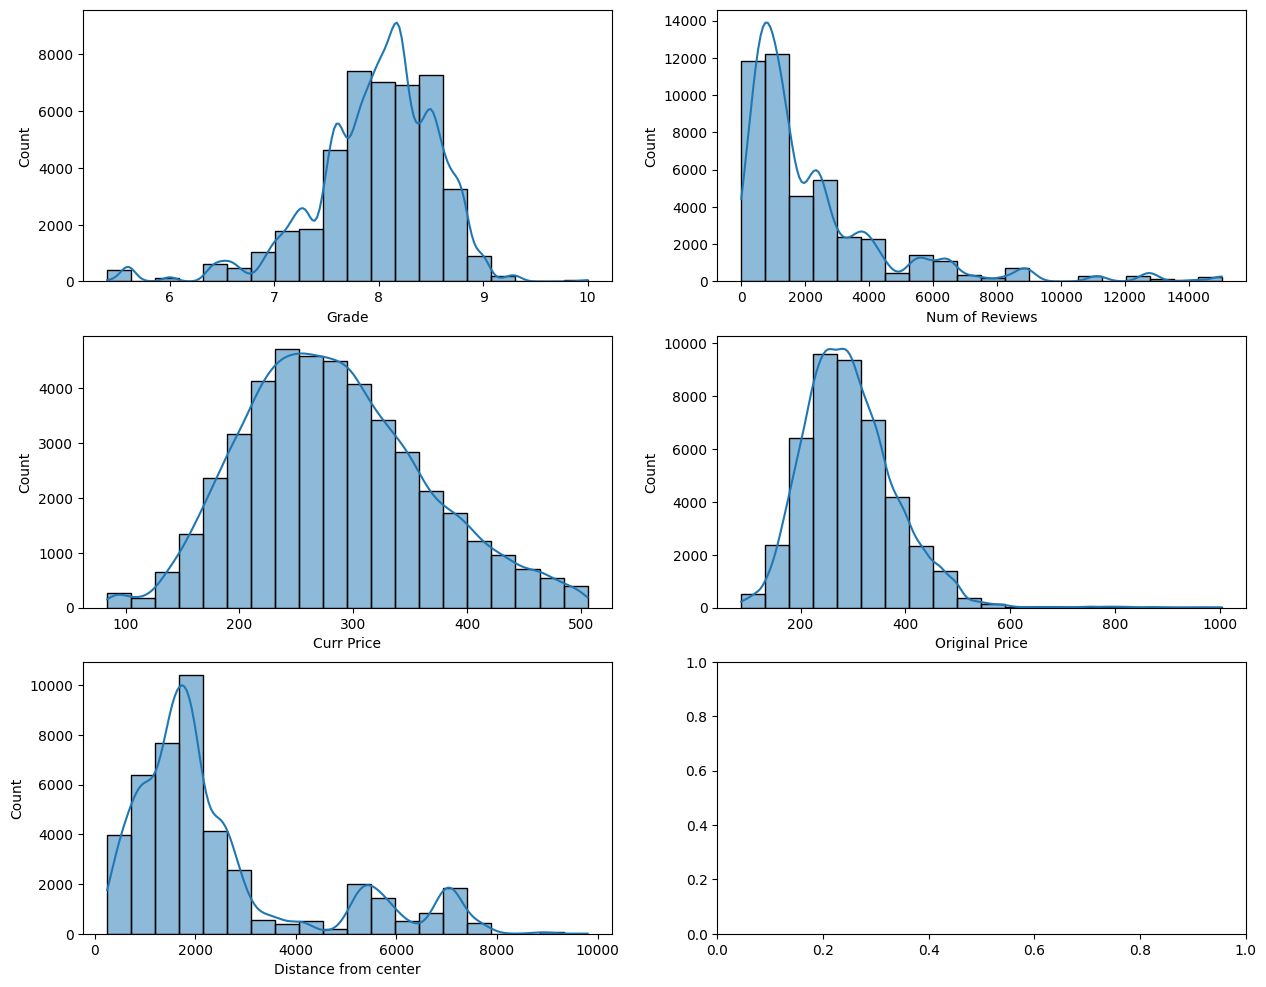

In [87]:
cols = booking_df.columns[5:10]
fig,axes = plt.subplots(3,2,figsize=(15,12))
for col,ax in zip(cols,axes.flatten()):
        sns.histplot(data=booking_df,x=col,ax=ax, bins=20 , kde =True)
    
booking_df[cols].describe().T

ציון -הציונים מתפלגים סביב 8
ביקורות - נוטה ימינה כך שהכי נפוץ כמות ביקורות בין 0 ל 2000
 המחיר כרגע - מתפלג נורצלית סביב  275
 המחיר המקורי - מתפלג נורמלית סביב 300
 מרחק מהמרכז - יש שני חלקים יש סוג מלונות מסויים שהוא מתפלג נורמלית בין 0 ל 3000 וסוג נוסף מתפלג בין 5000 ל 8000  

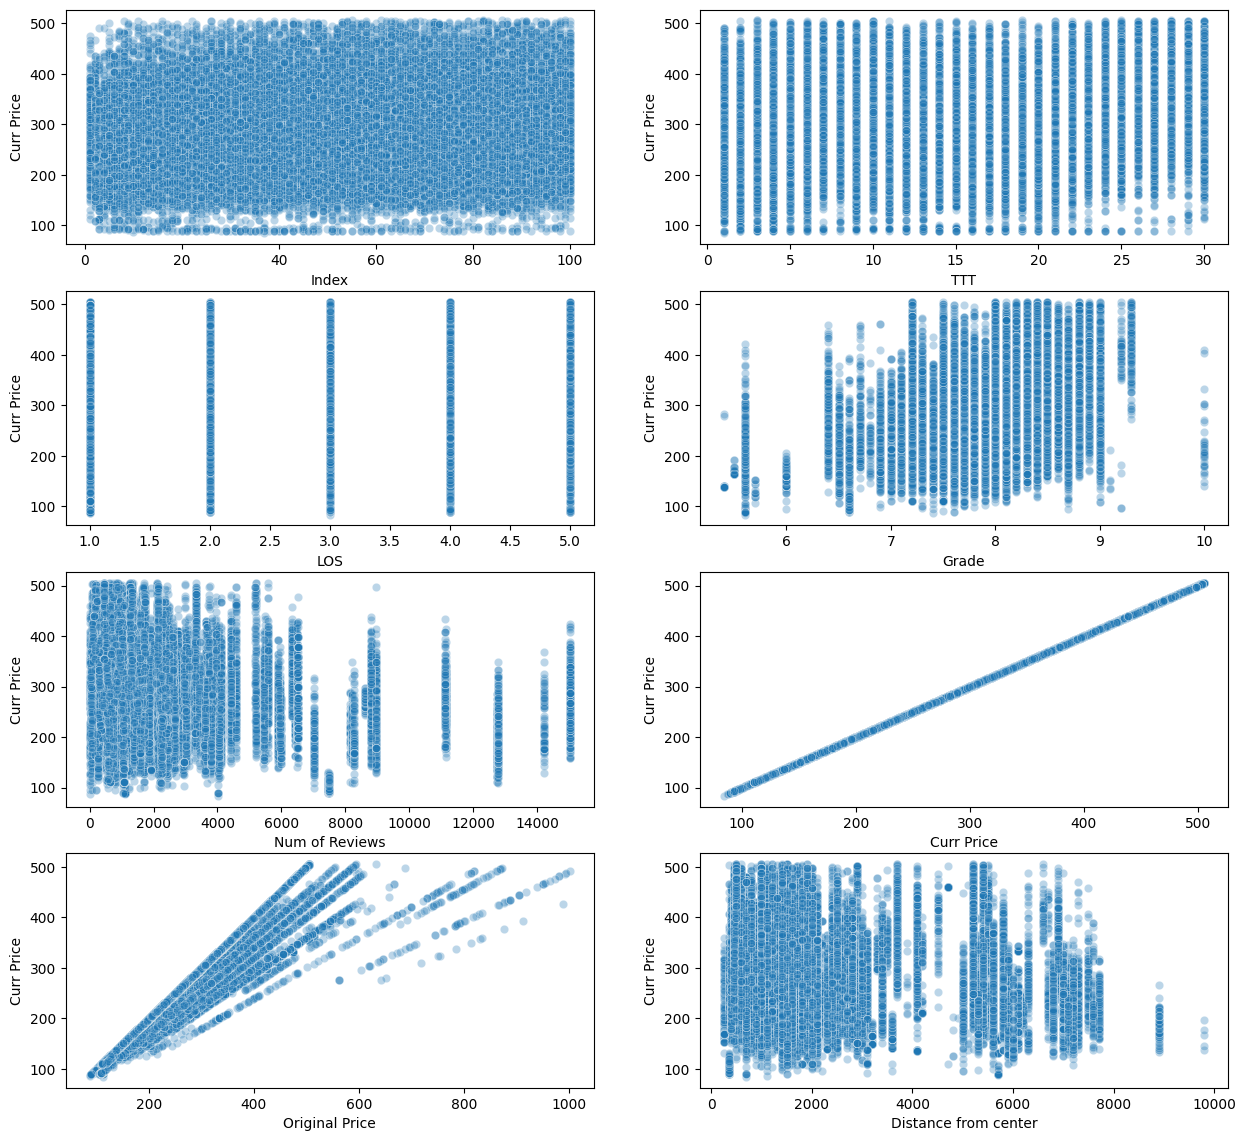

In [88]:
cols = booking_df.columns[1:10]
cols  = cols.drop(["Hotel Name"])
fig,axes = plt.subplots(4,2,figsize=(15,14))
for col,ax in zip(cols,axes.flatten()):
    sns.scatterplot(data = booking_df , x= col ,y = "Curr Price" , ax =ax ,alpha=0.3)
    

ציון - הציונים הנמוכים והגבוהים בעלי מחיר נמוך יחסית להתפלגות הציונים שהם ציונים בינוניים
ביקורות - ניתן לראות שהמלונות היקרים בעלי מספר נמוך של ביקורות
מחיר המקורי - מורכב מתתי קבוצות שמשקפים את המחיר כרגע
המרחק מהמרכז - ככול שהמרחק גדול יותר כך גם המלון זול יותר

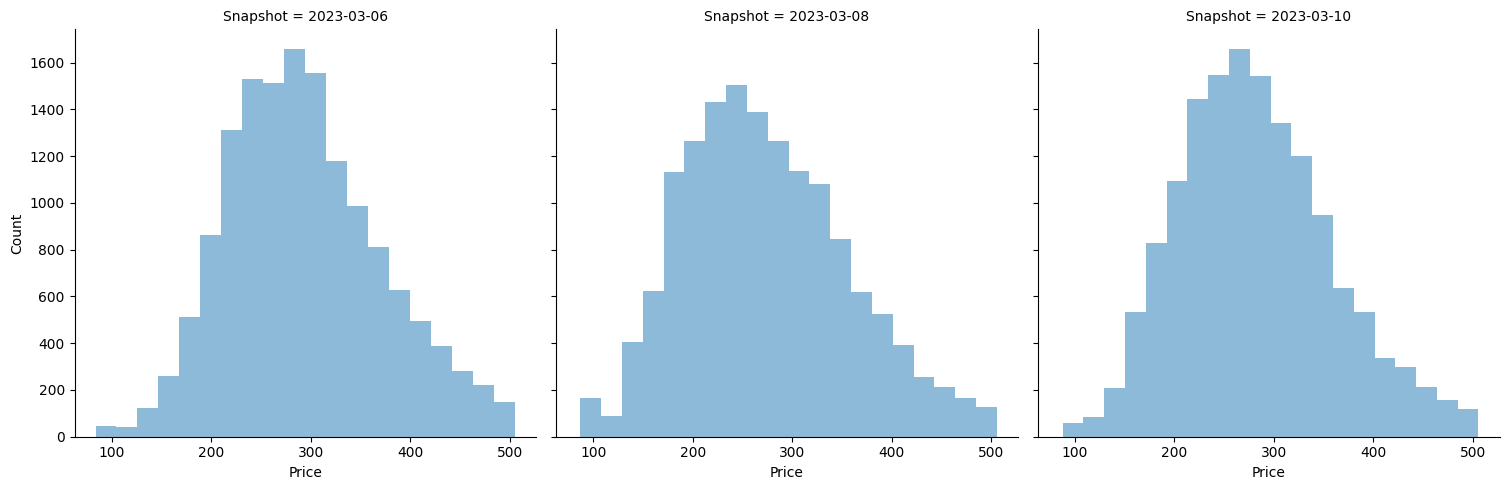

count        mean        std    min      25%      50%     75%  \
Snapshot                                                                      
2023-03-06  14555.0  294.256738  77.249009  83.88  238.525  286.580  343.01   
2023-03-08  14618.0  273.430767  82.350798  86.95  212.210  264.895  328.42   
2023-03-10  14782.0  281.574976  77.019687  87.79  226.520  274.840  329.64   

               max  
Snapshot            
2023-03-06  505.50  
2023-03-08  505.64  
2023-03-10  505.57

In [89]:
# Create a FacetGrid with three histograms
g = sns.FacetGrid(booking_df, col='Snapshot', height=5, aspect=1)
g = g.map(plt.hist, 'Curr Price', alpha=0.5, bins=20)

# Add labels to the plot
g.set_axis_labels('Price', 'Count')
plt.show()

booking_df.groupby('Snapshot')['Curr Price'].describe()

In [90]:
booking_df['Snapshot'] = pd.to_datetime(booking_df['Snapshot'])
booking_df['Snapshot'] = booking_df['Snapshot'].dt.day_name()
booking_df

Snapshot  Index                                         Hotel Name  TTT  \
0       Monday      1                 Margaritaville Resort Times Square    1   
1       Monday      2                          33 Seaport Hotel New York    1   
2       Monday      3                                The Belvedere Hotel    1   
3       Monday      4                                     CIVILIAN Hotel    1   
4       Monday      5                    The Cloud One New York-Downtown    1   
...        ...    ...                                                ...  ...   
44995   Friday     96      Aloft Manhattan Downtown - Financial District   30   
44996   Friday     97  Hampton Inn Manhattan/Downtown- Financial Dist...   30   
44997   Friday     98                                     Leon Hotel LES   30   
44998   Friday     99                                            SoHo 54   30   
44999   Friday    100                          New York Marriott Marquis   30   

       LOS  Grade  Num of Reviews  Curr Price  Original Price  \
0        1    8.8            1369      210.25          210.25   
1        1    8.6             284      293.57          293.57   
2        1    8.0            3644      142.59          142.59   
3        1    8.5            1172      214.45          214.45   
4        1    8.2             518      173.35          173.35   
...    ...    ...             ...         ...             ...   
44995    5    7.5            1106      214.78          214.78   
44996    5    7.6             658      249.34          249.34   
44997    5    8.1            1309      301.84          377.33   
44998    5    6.9            1562      214.72          238.55   
44999    5    8.2            1712      397.86          397.86   

       Distance from center                                    Type of room  \
0                      1500                             Standard Queen Room   
1                      6900                         Superior Courtyard King   
2                       900                              Standard King Room   
3                       900                                     Double Room   
4                      7000                              Standard King Room   
...                     ...                                             ...   
44995                  6800                             Guest room, 1 Queen   
44996                  7700                                      Queen Room   
44997                  5900                             Superior Queen Room   
44998                  5300                                       SoHo King   
44999                  1100  Renovated Deluxe, Guest room, 1 King, Sofa bed   

       Location grade  Free Cancellation  No prepayment needed  \
0                 9.4                  0                     0   
1                -1.0                  0                     0   
2                 9.4                  0                     0   
3                 9.5                  0                     0   
4                -1.0                  1                     1   
...               ...                ...                   ...   
44995            -1.0                  1                     0   
44996            -1.0                  1                     1   
44997            -1.0                  1                     1   
44998            -1.0                  1                     1   
44999             9.5                  0                     0   

       Breakfast included  Cancel Later  
0                       0             0  
1                       0             0  
2                       0             0  
3                       0             0  
4                       0             1  
...                   ...           ...  
44995                   0             1  
44996                   0             1  
44997                   0             1  
44998                   0             1  
44999                   0             0  

[4395

ניתן לראות לפי הממוצעים וסטיות התקן שאין משמעות ליום בשבוע שאתה מזמין עבור הדאטה סט הזה

בסקטור הזה נחקור את העמודה ציון מיקום

<Axes: xlabel='Location grade', ylabel='Curr Price'>

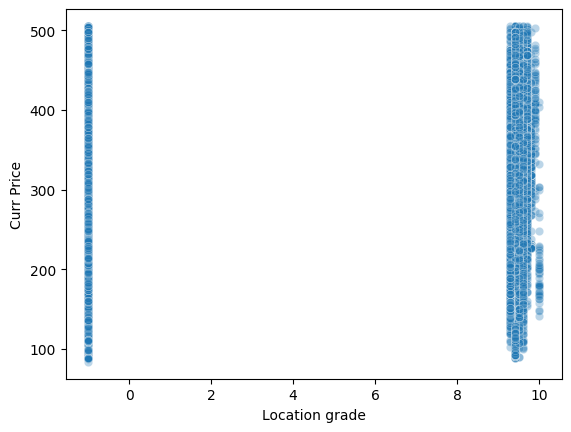

In [91]:
#without changes
sns.scatterplot(data = booking_df , x= 'Location grade' ,y = "Curr Price" ,alpha=0.3)


                Curr Price  Location grade
Curr Price        1.000000        0.234732
Location grade    0.234732        1.000000


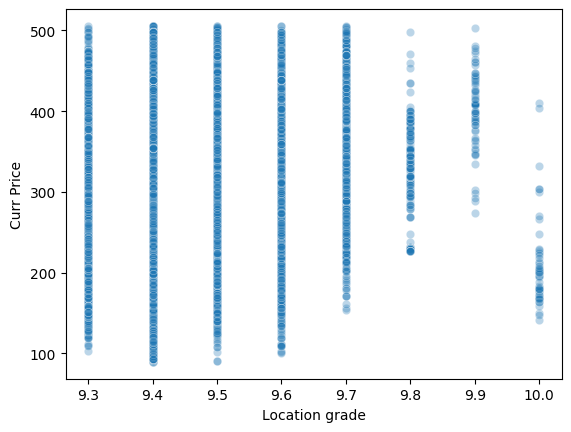

In [92]:
#drop None
df_test_location = booking_df[['Curr Price', 'Location grade']]
df_test_location = df_test_location[df_test_location['Location grade'] != -1]
sns.scatterplot(data = df_test_location , x= 'Location grade' ,y = "Curr Price" ,alpha=0.3)
print(df_test_location.corr())


<Axes: xlabel='Location grade', ylabel='Count'>

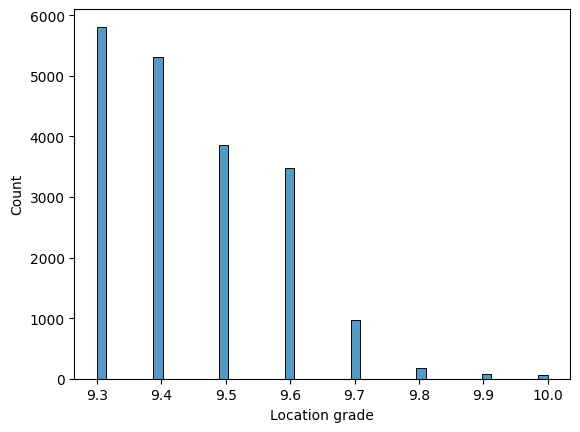

In [93]:
sns.histplot(data = df_test_location , x= 'Location grade')
    

                Curr Price  Location grade
Curr Price        1.000000        0.189642
Location grade    0.189642        1.000000
Distance from center mean: true  - false =  30.259317867130903


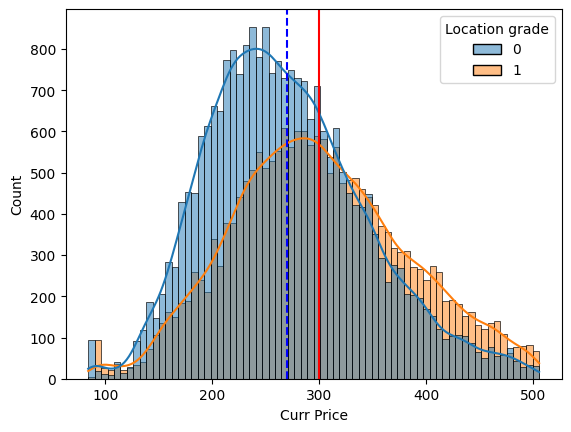

In [94]:
#change the column from numeric to binery
df_test_location2 = booking_df[['Curr Price', 'Location grade']]
df_test_location2['Location grade'] = df_test_location2['Location grade'].apply(lambda x: 0 if x ==-1 else 1)
sns.histplot(data=df_test_location2,x='Curr Price',hue = 'Location grade' ,kde =True)
print(df_test_location2.corr())
mean_1 =df_test_location2.loc[df_test_location2['Location grade']==1, "Curr Price"].mean()
plt.axvline(mean_1,c = 'r' , ls = '-')
mean_0 =df_test_location2.loc[df_test_location2['Location grade']==0, "Curr Price"].mean()
plt.axvline(mean_0,c = 'b' , ls = '--' )
print(col ,"mean: true  - false = " ,mean_1-mean_0 )

ראינו כי כשניסינו לשמור על המשתנה רציף על ידי הורדת עמודות התוצאות לא היו טובות
וכאשר ניסינו להפוך את העמודה לבינארית התוצאות היו טובות יותר ולכן נשנה את העמודה לבינארית

In [346]:
booking_df['Location grade'] = booking_df['Location grade'].apply(lambda x: 0 if x ==-1 else 1)
booking_df


Snapshot  Index                                         Hotel Name  \
0      2023-03-06      1                 Margaritaville Resort Times Square   
1      2023-03-06      2                          33 Seaport Hotel New York   
2      2023-03-06      3                                The Belvedere Hotel   
3      2023-03-06      4                                     CIVILIAN Hotel   
4      2023-03-06      5                    The Cloud One New York-Downtown   
...           ...    ...                                                ...   
44995  2023-03-10     96      Aloft Manhattan Downtown - Financial District   
44996  2023-03-10     97  Hampton Inn Manhattan/Downtown- Financial Dist...   
44997  2023-03-10     98                                     Leon Hotel LES   
44998  2023-03-10     99                                            SoHo 54   
44999  2023-03-10    100                          New York Marriott Marquis   

       TTT  LOS  Grade  Num of Reviews  Curr Price  Original Price  \
0        1    1    8.8            1369      210.25          210.25   
1        1    1    8.6             284      293.57          293.57   
2        1    1    8.0            3644      142.59          142.59   
3        1    1    8.5            1172      214.45          214.45   
4        1    1    8.2             518      173.35          173.35   
...    ...  ...    ...             ...         ...             ...   
44995   30    5    7.5            1106      214.78          214.78   
44996   30    5    7.6             658      249.34          249.34   
44997   30    5    8.1            1309      301.84          377.33   
44998   30    5    6.9            1562      214.72          238.55   
44999   30    5    8.2            1712      397.86          397.86   

       Distance from center                                    Type of room  \
0                      1500                             Standard Queen Room   
1                      6900                         Superior Courtyard King   
2                       900                              Standard King Room   
3                       900                                     Double Room   
4                      7000                              Standard King Room   
...                     ...                                             ...   
44995                  6800                             Guest room, 1 Queen   
44996                  7700                                      Queen Room   
44997                  5900                             Superior Queen Room   
44998                  5300                                       SoHo King   
44999                  1100  Renovated Deluxe, Guest room, 1 King, Sofa bed   

       Location grade  Free Cancellation  No prepayment needed  \
0                   1                  0                     0   
1                   0                  0                     0   
2                   1                  0                     0   
3                   1                  0                     0   
4                   0                  1                     1   
...               ...                ...                   ...   
44995               0                  1                     0   
44996               0                  1                     1   
44997               0                  1                     1   
44998               0                  1                     1   
44999               1                  0                     0   

       Breakfast included  Cancel Later  
0                       0             0  
1                       0             0  
2                       0             0  
3                       0             0  
4                       0             1  
...                   ...           ...  
44995                   0             1  
44996                   0             1  
44997                   0             1  
44998                   0             1  
44999          